In [1]:
import itertools
import math

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import SimpleITK as sitk

from scipy.stats import pearsonr
from sklearn.metrics import auc

import glioseg.constants as constants

from glioseg.segmentation.tumor.validation.metrics_nnunet import compute_dice_score
from glioseg.segmentation.tumor.validation.metrics_nnunet import extract_label
from glioseg.segmentation.tumor.validation.metrics_nnunet import same_physical_space


def compute_confidence_score_single_output(input_dir, segmentation_dict, labels, output_dir):
    
    """
    Compute confidence score based on model ensemble candidates.
    For each patient: compute the mean over ALL pairwise model Dice scores
    (macro and micro). No per-method results.
    """

    if not isinstance(input_dir, Path):
        input_dir = Path(input_dir)
    if not isinstance(output_dir, Path):
        output_dir = Path(output_dir)

    all_results = []
    all_results_per_patient = []

    for patient in sorted(input_dir.iterdir()):

        segmentations_dir = patient.joinpath("SEGMENTATIONS", "NIFTI")

        # Load all model segmentations
        seg_images = {}
        for method, seg_file_name in segmentation_dict.items():
            seg_file = segmentations_dir.joinpath(
                constants.TUMOR_MASK_NAME + seg_file_name + "_T1GD"
            ).with_suffix(constants.NIFTI_EXTENSION)

            # fallback to non-relabelled version
            if not seg_file.exists() and "_relabelled" in seg_file_name:
                clean_name = seg_file_name.replace("_relabelled", "")
                print(f"Missing relabelled seg → using {clean_name}")
                seg_file = segmentations_dir.joinpath(
                    constants.TUMOR_MASK_NAME + clean_name + "_T1GD"
                ).with_suffix(constants.NIFTI_EXTENSION)

            if seg_file.exists():
                seg_images[method] = sitk.ReadImage(str(seg_file), sitk.sitkUInt8)
            else:
                print(f"Skipping {method}: file not found {seg_file}")

        methods = list(seg_images.keys())
        if len(methods) < 2:
            print(f"Skipping {patient.name}: <2 segmentations.")
            continue

        # Accumulate pairwise macro & micro Dice scores
        macro_scores = {}
        micro_scores = {}

        for m1, m2 in itertools.combinations(methods, 2):
            seg1, seg2 = seg_images[m1], seg_images[m2]

            if not same_physical_space(seg1, seg2):
                seg2.CopyInformation(seg1)

            per_label_dices = []
            total_intersection = 0
            total_union = 0

            for label in labels:
                s1_label = extract_label(seg1, label)
                s2_label = extract_label(seg2, label)

                # Macro
                dice = compute_dice_score(s1_label, s2_label)
                per_label_dices.append(dice)

                # Micro
                s1_arr = sitk.GetArrayFromImage(s1_label) > 0
                s2_arr = sitk.GetArrayFromImage(s2_label) > 0
                total_intersection += np.sum(s1_arr & s2_arr)
                total_union += np.sum(s1_arr) + np.sum(s2_arr)

            macro_scores[(m1, m2)] = np.mean(per_label_dices)

            micro_scores[(m1, m2)] = 2 * total_intersection / (total_union + 1e-6)

        final_macro = np.mean(list(macro_scores.values()))
        final_micro = np.mean(list(micro_scores.values()))

        all_results.append(
            {
                "Patient": patient.name,
                "PW-DSC": final_macro,
                "PW-MCDSC": final_micro,
            }
        )

        all_results_per_patient.append(
            {
                "Patient": patient.name,
                "PW-DSC-combinations": macro_scores,
                "PW-MCDSC-combinations": micro_scores,
            }
        )

    results_extended = pd.DataFrame(all_results_per_patient)
    output_file_extended = output_dir.joinpath("confidence_candidates_extended.csv")
    results_extended.to_csv(output_file_extended, index=False)
    print(f"Extended confidence metrics saved to {output_file_extended}")

    # Save final results
    results = pd.DataFrame(all_results)
    output_file = output_dir.joinpath("confidence_candidates_summary.csv")
    results.to_csv(output_file, index=False)
    print(f"Summary confidence metrics saved to {output_file}")

    return results, results_extended

In [2]:
def compute_multiclass_dice_score(input_dir, gt_dir, mean_models_dict, labels, ouput_dir):

    if not isinstance(input_dir, Path):
        input_dir = Path(input_dir)
    if not isinstance(gt_dir, Path):
        gt_dir = Path(gt_dir)
    if not isinstance(ouput_dir, Path):
        ouput_dir = Path(ouput_dir)

    all_results = []

    for patient in sorted(input_dir.iterdir()):

        segmentations_dir = patient.joinpath("SEGMENTATIONS", "NIFTI")
        gt_file = gt_dir.joinpath(patient.name, "NIFTI", "MASK_original.nii.gz")

        if not gt_file.exists():
            gt_file = gt_dir.joinpath(patient.name, "NIFTI", "MASK.nii.gz")

        gt_im = sitk.ReadImage(str(gt_file), sitk.sitkUInt8)

        seg_images = {}

        for method, seg_file_name in mean_models_dict.items():

            seg_file = segmentations_dir.joinpath(
                constants.TUMOR_MASK_NAME + seg_file_name + "_T1GD"
            ).with_suffix(constants.NIFTI_EXTENSION)

            if not seg_file.exists() and "_relabelled" in seg_file_name:
                seg_file_name = seg_file_name.replace("_relabelled", "")
                print(
                    f"Segmentation file {seg_file} does not exist, and its relabelled. Using the non-relabelled insead"
                )
                print(f"Using instead {seg_file_name}")
                seg_file = segmentations_dir.joinpath(
                    constants.TUMOR_MASK_NAME + seg_file_name + "_T1GD"
                ).with_suffix(constants.NIFTI_EXTENSION)
            if seg_file.exists():
                seg_images[method] = sitk.ReadImage(str(seg_file), sitk.sitkUInt8)
                if not same_physical_space(gt_im, seg_images[method]):
                    seg_images[method].CopyInformation(gt_im)
                dice_scores_labels = []
                total_intersection = 0
                total_union = 0
                for label in labels:
                    gt_label = extract_label(gt_im, label)
                    seg_label = extract_label(seg_images[method], label)

                    gt_arr = sitk.GetArrayFromImage(gt_label) > 0
                    seg_arr = sitk.GetArrayFromImage(seg_label) > 0

                    total_intersection += np.sum(gt_arr & seg_arr)
                    total_union += np.sum(gt_arr) + np.sum(seg_arr)

                    dice_score_per_label = compute_dice_score(gt_label, seg_label)
                    dice_scores_labels.append(dice_score_per_label)

                mean_dice_score_vs_gt = np.mean(dice_scores_labels)
                multiclass_dice_score_vs_gt = 2 * total_intersection / (total_union + 1e-6)
                all_results.append(
                    {
                        "Patient": patient.name,
                        "Method": method,
                        "GT-DSC": mean_dice_score_vs_gt,
                        "GT-MCDSC": multiclass_dice_score_vs_gt,
                    }
                )
            else:
                print(f"Skipping {method}: file not found {seg_file}")
                continue

    results = pd.DataFrame(all_results)
    output_file = ouput_dir.joinpath("multiclass_dice_score.csv")
    results.to_csv(output_file, index=False)
    print(f"Quality assessment results vs GT saved to {output_file}")

    return results

In [3]:
def plot_quality_vs_risk(
    confidence_candidates_summary_df: pd.DataFrame,
    multiclass_dice_score_df: pd.DataFrame,
    model_keys: str | list[str] | None,
    output_dir: str | Path,
    metric_compute: str,
):
    """
    Plot PW-DSC (x-axis) vs Risk (1 - GT-DSC) (y-axis) for one or more models.

    Args:
        confidence_candidates_summary_df (pd.DataFrame): Must contain ["Patient", "PW-DSC", "PW-MCDSC"].
        multiclass_dice_score_df (pd.DataFrame): Must contain ["Patient", "Method", "GT-DSC", "GT-MCDSC"].
        model_keys (str | list[str] | None): Model(s) to plot.
            - str → single model plot
            - list[str] → multiple models, one subplot each
            - None → all models found in multiclass_dice_score_df
        output_dir (str | Path): Directory to save outputs.
        metric_compute (str): Type of metric either "macro" or "micro". If "macro", it corresponds to the mean per-label Dice score,
        if "micro", it corresponds to the multiclass Dice score.
    """

    output_dir.mkdir(parents=True, exist_ok=True)

    if not isinstance(output_dir, Path):
        output_dir = Path(output_dir)

    # --- Determine models to plot ---
    if model_keys is None:
        models_to_plot = multiclass_dice_score_df["Method"].unique()
    elif isinstance(model_keys, str):
        models_to_plot = [model_keys]
    elif isinstance(model_keys, list):
        models_to_plot = model_keys
    else:
        raise ValueError("model_keys must be None, a string, or a list of strings.")

    assert metric_compute in ["macro", "micro"], "metric_compute must be either 'macro' or 'micro'"

    if metric_compute == "macro":
        GT_key = "GT-DSC"
        confidence_key = "PW-DSC"
    else:
        GT_key = "GT-MCDSC"
        confidence_key = "PW-MCDSC"

    n_models = len(models_to_plot)

    # --- Handle single vs multiple models ---
    if n_models == 1:

        model = models_to_plot[0]
        multiclass_dice_model = multiclass_dice_score_df[
            multiclass_dice_score_df["Method"] == model
        ].copy()
        if multiclass_dice_model.empty:
            print(f"No entries found for model '{model}'")
            return

        multiclass_dice_model["Risk"] = 1 - multiclass_dice_model[GT_key]

        x, y = (
            confidence_candidates_summary_df[confidence_key].values,
            multiclass_dice_model["Risk"].values,
        )

        r_value, p_value = pearsonr(x, y)
        slope, intercept = np.polyfit(x, y, 1)

        plt.figure(figsize=(6, 6))
        plt.scatter(x, y, color="tab:blue", edgecolor="k", s=70, alpha=0.8, label=f"r = {r_value:.3f}")
        # plt.plot(
        #     x, slope * x + intercept, color="red", linestyle="--", linewidth=2, label="Linear fit"
        # )
        # plt.title(
        #     f"{model}\nPearson r={r_value:.3f}, p={p_value:.3e}", fontsize=11, fontweight="bold"
        # )
        plt.xlabel(f"Confidence ({confidence_key})")
        plt.ylabel(f"Risk (1- {GT_key})")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.legend()

        output_file = output_dir / f"scatter_confidence_vs_risk{metric_compute}.svg"

        plt.tight_layout()
        plt.savefig(output_file, dpi=300)
        plt.show()
        plt.close()

        print(f"Saved scatter plot for model '{model}' → {output_file}")
        print(f"   Pearson r = {r_value:.3f}, p = {p_value:.3e}")

        # return {
        #     "Model": model,
        #     "Pearson_r": r_value,
        #     "p_value": p_value,
        #     "Output_File": str(output_file),
        # }

        plt.tight_layout()
        # Do NOT plt.show() or plt.close()

        return fig, ax, {
            "Model": model,
            "Pearson_r": r_value,
            "p_value": p_value,
            "Output_File": str(output_file),
        }
    
    else:
        # --- Multi-model figure ---

        if n_models <= 3:
            n_rows = 1
            n_cols = n_models
        else:
            n_cols = math.ceil(math.sqrt(n_models))
            n_rows = math.ceil(n_models / n_cols)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
        axes = np.array(axes).flatten()

        correlation_records = []

        for i, model in enumerate(models_to_plot):

            ax = axes[i]
            multiclass_dice_model = multiclass_dice_score_df[
                multiclass_dice_score_df["Method"] == model
            ].copy()

            if multiclass_dice_model.empty:
                ax.set_visible(False)
                continue

            multiclass_dice_model["Risk"] = 1 - multiclass_dice_model[GT_key]
            x, y = (
                confidence_candidates_summary_df[confidence_key].values,
                multiclass_dice_model["Risk"].values,
            )

            r_value, p_value = pearsonr(x, y)
            slope, intercept = np.polyfit(x, y, 1)

            ax.scatter(x, y, color=f"C{i % 10}", edgecolor="k", s=70, alpha=0.8)
            ax.plot(x, slope * x + intercept, color="red", linestyle="--", linewidth=2)
            # ax.set_title(
            #     f"{model}\nr={r_value:.3f}, p={p_value:.3e}", fontsize=10, fontweight="bold"
            # )
            ax.set_xlabel(f"Confidence ({confidence_key})")
            ax.set_ylabel(f"Risk (1 - {GT_key})")
            ax.grid(True, linestyle="--", alpha=0.5)

            correlation_records.append({"Model": model, "Pearson_r": r_value, "p_value": p_value})

        # Remove unused subplots
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        # fig.suptitle("PW-DSC vs Risk (1 - GT-DSC) per model", fontsize=14, fontweight="bold")
        fig.tight_layout(rect=[0, 0, 1, 0.96])

        output_file = output_dir / f"scatter_QA_vs_Risk_{metric_compute}.svg"
        
        plt.show()
        plt.savefig(output_file, dpi=300)
        plt.close()

        corr_df = pd.DataFrame(correlation_records)
        corr_csv = output_dir / f"correlation_summary_{metric_compute}.csv"
        corr_df.to_csv(corr_csv, index=False)

        print(f"Saved multi-model figure {output_file}")
        print(f"Correlation summary saved {corr_csv}")



In [ ]:
def confidence_vs_risk_figure(
    confidence_candidates_summary_df: pd.DataFrame,
    multiclass_dice_score_df: pd.DataFrame,
    model_key: str,
    metric_compute: str,      
): 
    
    """
    Plot PW-DSC (x-axis) vs Risk (1 - GT-DSC) (y-axis) for one model.

    Args:
        confidence_candidates_summary_df (pd.DataFrame): Must contain ["Patient", "PW-DSC", "PW-MCDSC"].
        multiclass_dice_score_df (pd.DataFrame): Must contain ["Patient", "Method", "GT-DSC", "GT-MCDSC"].
        model_key (str): Model to plot.
        metric_compute (str): Type of metric either "macro" or "micro". If "macro", it corresponds to the mean per-label Dice score,
        if "micro", it corresponds to the multiclass Dice score.
    """


    assert metric_compute in ["macro", "micro"], "metric_compute must be either 'macro' or 'micro'"

    if metric_compute == "macro":
        GT_key = "GT-DSC"
        confidence_key = "PW-DSC"
    else:
        GT_key = "GT-MCDSC"
        confidence_key = "PW-MCDSC"
        
    multiclass_dice_model = multiclass_dice_score_df[
        multiclass_dice_score_df["Method"] == model_key
    ].copy()

    if multiclass_dice_model.empty:
        print(f"No entries found for model '{model_key}'")
        return

    multiclass_dice_model["Risk"] = 1 - multiclass_dice_model[GT_key]

    x, y = (
        confidence_candidates_summary_df[confidence_key].values,
        multiclass_dice_model["Risk"].values,
    )

    r_value, _ = pearsonr(x, y)

    fig, ax = plt.subplots(figsize=(6,6))

    ax.scatter(x, y, color="tab:blue", edgecolor="k", s=70, alpha=0.8, label=f"r = {r_value:.3f}")
    ax.set_xlabel(f"Confidence ({confidence_key})")
    ax.set_ylabel(f"Risk (1- {GT_key})")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend()

    plt.tight_layout()
    # Do NOT plt.show() or plt.close()

    return fig, ax 

def risk_coverage_figure(    
    confidence_candidates_summary_df: pd.DataFrame,
    multiclass_dice_score_df: pd.DataFrame,
    model_key: str,
    metric_compute: str):
    
    """
    Generate risk–coverage curves for one, several, or all models.
    Each subplot shows:
        - Empirical risk–coverage curve (PW-DSC vs GT-DSC)
        - Optimal curve (best possible ordering by GT-DSC)
        - AUC of empirical curve

    Args:
        confidence_candidates_summary_df (pd.DataFrame): Must contain ['Patient', 'PW-DSC', 'PW-MCDSC'].
        multiclass_dice_score_df (pd.DataFrame): Must contain ['Patient', 'Method', 'GT-DSC', 'GT-MCDSC'].
        output_dir (str | Path): Directory to save outputs.
        model_key (str): Which model to plot.
        metric_compute (str): Type of GT Dice to use, either "macro" or "micro". If "macro", it corresponds to the mean per-label Dice score,
        if "micro", it corresponds to the multiclass Dice score.

    """


    assert metric_compute in ["macro", "micro"], "metric_compute must be either 'macro' or 'micro'"

    if metric_compute == "macro":
        GT_key = "GT-DSC"
        confidence_key = "PW-DSC"
    else:
        GT_key = "GT-MCDSC"
        confidence_key = "PW-MCDSC"

    fig, axes = plt.subplots(figsize=(6,6))

    multiclass_dice_score_method_df = multiclass_dice_score_df[
        multiclass_dice_score_df["Method"] == model_key
    ].copy()

    total_cases = len(multiclass_dice_score_method_df)

    thresholds = np.linspace(0, 1, total_cases)

    if total_cases == 0:
        print(f"No entries found for model '{model_key}'")
        return 

    sorted_risks = 1 - np.sort(multiclass_dice_score_method_df[GT_key].values)[::-1]

    coverages, avg_risks, optimal_risks, detailed_results = [], [], [], []

    for t in thresholds: 

        # Empirical curve 

        subset_confidence = confidence_candidates_summary_df[
            confidence_candidates_summary_df[confidence_key] >= t
        ]

        subset_risk = multiclass_dice_score_method_df[
            multiclass_dice_score_method_df["Patient"].isin(subset_confidence["Patient"])
        ]

        coverage = len(subset_confidence) / total_cases 
        avg_risk = np.mean(1 - subset_risk[GT_key]) if len(subset_risk) > 0 else 0

        # Optimal curve 

        k = len(subset_risk)
        optimal_risk = np.mean(sorted_risks[:k]) if k > 0 else 0

        detailed_results.append({
            "Threshold": t,
            "Coverage": coverage,
            "Avg_Risk": avg_risk,
            "Optimal_Risk": optimal_risk,
        })

        coverages.append(coverage)
        avg_risks.append(avg_risk)
        optimal_risks.append(optimal_risk)
        
    
    coverages = np.array(coverages)
    avg_risks = np.array(avg_risks)
    optimal_risks = np.array(optimal_risks)

    auc_value = auc(coverages, avg_risks)
    optimal_auc = auc(coverages, optimal_risks)

    area_between = np.abs(auc_value - optimal_auc)

    auc_results = pd.DataFrame.from_dict({
        "AUC": [auc_value], 
        "Optimal AUC": [optimal_auc],
        "Area Between": [area_between],
    })

    axes.plot(coverages, avg_risks, lw = 2, color= "c")
    axes.fill_between(coverages, avg_risks, alpha = 0.2, color="blue", label = f"AUC {auc_value:.3f}")

    axes.plot(coverages, optimal_risks, "--", lw=2, color="black", alpha=0.6, label="Optimal")

    axes.set_xlabel("Coverage")
    axes.set_ylabel(f"Average Risk (1 - {GT_key})")
    axes.set_xlim(0, 1)
    axes.set_ylim(0, 1)
    axes.grid(True, ls="--", alpha=0.3)
    axes.legend()

    return fig, axes, detailed_results, auc_results


In [ ]:
def plot_risk_coverage_subplots(
    confidence_candidates_summary_df: pd.DataFrame,
    multiclass_dice_score_df: pd.DataFrame,
    model_keys: str | list[str] | None,
    output_dir: str | Path,
    metric_compute: str,
):

    """
    Generate risk–coverage curves for one, several, or all models.
    Each subplot shows:
        - Empirical risk–coverage curve (PW-DSC vs GT-DSC)
        - Optimal curve (best possible ordering by GT-DSC)
        - AUC of empirical curve

    Args:
        confidence_candidates_summary_df (pd.DataFrame): Must contain ['Patient', 'PW-DSC', 'PW-MCDSC'].
        multiclass_dice_score_df (pd.DataFrame): Must contain ['Patient', 'Method', 'GT-DSC', 'GT-MCDSC'].
        output_dir (str | Path): Directory to save outputs.
        model_keys (str | list[str] | None): Which models to plot. None = all.
        metric_compute (str): Type of GT Dice to use, either "macro" or "micro". If "macro", it corresponds to the mean per-label Dice score,
        if "micro", it corresponds to the multiclass Dice score.

    """

    output_dir.mkdir(parents=True, exist_ok=True)

    # Select models
    if model_keys is None:
        methods = multiclass_dice_score_df["Method"].unique()
    elif isinstance(model_keys, str):
        methods = [model_keys]
    else:
        methods = model_keys

    assert metric_compute in ["macro", "micro"], "metric_compute must be either 'macro' or 'micro'"

    if metric_compute == "macro":
        GT_key = "GT-DSC"
        confidence_key = "PW-DSC"
    else:
        GT_key = "GT-MCDSC"
        confidence_key = "PW-MCDSC"

    n_methods = len(methods)

    if n_methods <= 3:
        n_rows = 1
        n_cols = n_methods
    else:
        n_cols = math.ceil(math.sqrt(n_methods))
        n_rows = math.ceil(n_methods / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
    axes = np.array(axes).reshape(-1)

    auc_results, detailed_results = [], []

    for i, method in enumerate(methods):

        ax = axes[i]
        multiclass_dice_score_method_df = multiclass_dice_score_df[
            multiclass_dice_score_df["Method"] == method
        ].copy()
        total_cases = len(multiclass_dice_score_method_df)
        thresholds = np.linspace(0, 1, total_cases)  # threshold sweep
        if total_cases == 0:
            continue

        sorted_risks = 1 - np.sort(multiclass_dice_score_method_df[GT_key].values)[::-1]

        coverages, avg_risks, optimal_risks = [], [], []

        for t in thresholds:
            # Empirical curve
            subset_confidence = confidence_candidates_summary_df[
                confidence_candidates_summary_df[confidence_key] >= t
            ]
            subset_risk = multiclass_dice_score_method_df[
                multiclass_dice_score_method_df["Patient"].isin(subset_confidence["Patient"])
            ]

            coverage = len(subset_confidence) / total_cases
            avg_risk = np.mean(1 - subset_risk[GT_key]) if len(subset_risk) > 0 else 0.0

            # Optimal curve: take top-k by ordered risk (same k as empirical coverage)
            k = len(subset_risk)
            optimal_risk = np.mean(sorted_risks[:k]) if k > 0 else 0.0

            coverages.append(coverage)
            avg_risks.append(avg_risk)
            optimal_risks.append(optimal_risk)

            # Save detailed threshold info
            detailed_results.append(
                {
                    "Method": method,
                    "Threshold": round(t, 3),
                    "Coverage": coverage,
                    "Average_Risk": avg_risk,
                    "Optimal_Risk": optimal_risk,
                }
            )

        coverages = np.array(coverages)
        avg_risks = np.array(avg_risks)
        optimal_risks = np.array(optimal_risks)

        auc_value = auc(coverages, avg_risks)
        optimal_auc = auc(coverages, optimal_risks)

        area_between = np.abs(auc_value - optimal_auc)

        score = np.mean([auc_value, area_between])

        auc_results.append(
            {
                "Method": method,
                "AUC": auc_value,
                "AUC_Optimal": optimal_auc,
                "Area_Between": area_between,
                "Score": score,
            }
        )

        # Plot curves
        # ax.plot(coverages, avg_risks, "o-", lw=2, color=f"C{i%10}", label="Empirical")
        ax.plot(coverages, avg_risks, lw=2, color=f"C{i%10}")
        ax.fill_between(
            coverages, avg_risks, alpha=0.2, color=f"C{i%10}", label=f"AUC {auc_value:.3f}"
        )  # shaded area
        ax.plot(coverages, optimal_risks, "--", lw=2, color="black", alpha=0.6, label="Optimal")
        # ax.set_title(
        #     f"{method}\n GAP-AUC={area_between:.3f} \n Score={score:.3f}",
        #     fontsize=11,
        #     fontweight="bold",
        # )
        ax.set_xlabel("Coverage")
        ax.set_ylabel(f"Average Risk (1 - {GT_key})")
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.grid(True, ls="--", alpha=0.3)
        ax.legend()

    # Remove extra axes if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # fig.suptitle("Risk–Coverage Curves per Method", fontsize=14, fontweight="bold")
    fig.tight_layout(rect=[0, 0, 1, 0.97])

    # Save figure
    fig_path = output_dir / f"risk_coverage_subplots_{metric_compute}.svg"
    plt.savefig(fig_path)

    # Save AUC table
    auc_df = pd.DataFrame(auc_results)
    auc_df_path = output_dir / f"risk_coverage_auc_{metric_compute}.csv"
    auc_df.to_csv(auc_df_path, float_format="%.3f", index=False)

    # Save detailed threshold results
    detailed_df = pd.DataFrame(detailed_results)
    detailed_df_path = output_dir / f"risk_coverage_detailed_{metric_compute}.csv"
    detailed_df.to_csv(detailed_df_path, float_format="%.3f", index=False)

    print(f"Saved figure to {fig_path}")
    print(f"Saved AUC table to {auc_df_path}")
    print(f"Saved detailed threshold data to {detailed_df_path}")

In [ ]:
# output_dir = Path("/scratch/radv/share/glioseg/new_run_corrected/segmentation_quality")
# output_dir.mkdir(parents=True, exist_ok=True)
# output_dir_before_relabeling = output_dir.joinpath("before_relabeling")
# output_dir_before_relabeling.mkdir(parents=True, exist_ok=True)
# right_results_before_relabeling = output_dir_before_relabeling.joinpath("right")
# right_results_before_relabeling.mkdir(parents=True, exist_ok=True)
# wrong_results_before_relabeling = output_dir_before_relabeling.joinpath("wrong")
# wrong_results_before_relabeling.mkdir(parents=True, exist_ok=True)
# output_dir_after_relabeling = output_dir.joinpath("after_relabeling")
# output_dir_after_relabeling.mkdir(parents=True, exist_ok=True)
# right_results_after_relabeling = output_dir_after_relabeling.joinpath("right")
# right_results_after_relabeling.mkdir(parents=True, exist_ok=True)   
# wrong_results_after_relabeling = output_dir_after_relabeling.joinpath("wrong")
# wrong_results_after_relabeling.mkdir(parents=True, exist_ok=True)

In [7]:
segmentation_files_dict_before_relabeling = {
    "nnUNet": constants.NNUNET_TASK001_TASK082_ENSEMBLE_SEGMENTATION_NAME,
    "BraTS21": constants.NNUNET_TASK500_ENSEMBLE_SEGMENTATION_NAME,
    "HDglio": constants.HDGLIO_SEGMENTATION_NAME,
    "DeepSCAN": constants.SCAN2020_SEGMENTATION_NAME,
    "FETS": constants.FETS_SEGMENTATION_NAME,
}

segmentation_files_dict_after_relabeling = {
    "nnUNet": constants.NNUNET_TASK001_TASK082_ENSEMBLE_SEGMENTATION_NAME
    + constants.RELABELLED_NAME,
    "BraTS21": constants.NNUNET_TASK500_ENSEMBLE_SEGMENTATION_NAME + constants.RELABELLED_NAME,
    "HDglio": constants.HDGLIO_SEGMENTATION_NAME + constants.RELABELLED_NAME,
    "DeepSCAN": constants.SCAN2020_SEGMENTATION_NAME + constants.RELABELLED_NAME,
    "FETS": constants.FETS_SEGMENTATION_NAME + constants.RELABELLED_NAME,
}

mean_segmentation_files_dict_before_relabeling = {
    "MV": constants.ENSEMBLED_MAJORITY_SEGMENTATION_NAME,
    "STAPLE": constants.ENSEMBLED_SEGMENTATION_NAME,
    "SIMPLE": constants.ENSEMBLED_SIMPLE_SEGMENTATION_NAME,
}

mean_segmentation_files_dict_after_relabeling = {
    "MV": constants.ENSEMBLED_MAJORITY_SEGMENTATION_NAME + constants.RELABELLED_NAME,
    "STAPLE": constants.ENSEMBLED_SEGMENTATION_NAME + constants.RELABELLED_NAME,
    "SIMPLE": constants.ENSEMBLED_SIMPLE_SEGMENTATION_NAME + constants.RELABELLED_NAME,
}

input_dir = Path("/scratch/radv/share/glioseg/new_run_corrected/Patients")
gt_dir = Path("/scratch/radv/share/glioseg/new_run_corrected/GT/")
labels = [1, 2, 3]

output_dir = Path("/scratch/radv/share/glioseg/new_run_corrected/segmentation_quality")
output_dir.mkdir(parents=True, exist_ok=True)
output_dir_before_relabeling = output_dir.joinpath("before_relabeling")
output_dir_before_relabeling.mkdir(parents=True, exist_ok=True)
output_dir_after_relabeling = output_dir.joinpath("after_relabeling")
output_dir_after_relabeling.mkdir(parents=True, exist_ok=True)


# print(list(itertools.combinations(segmentation_files_dict_before_relabeling.keys(), 2)))
# print(len(list(itertools.combinations(segmentation_files_dict_before_relabeling.keys(), 2))))

confidence_score_before_relabel, extended_confidence_before_relabel = compute_confidence_score_single_output(
    input_dir=input_dir,
    segmentation_dict=segmentation_files_dict_before_relabeling,
    labels=labels,
    output_dir=output_dir_before_relabeling,
)
confidence_score_after_relabel, extended_confidence_after_relabel = compute_confidence_score_single_output(
    input_dir=input_dir,
    segmentation_dict=segmentation_files_dict_after_relabeling,
    labels=labels,
    output_dir=output_dir_after_relabeling,
)

multiclass_dice_score_before_relabel = compute_multiclass_dice_score(
    input_dir=input_dir,
    gt_dir=gt_dir,
    mean_models_dict=mean_segmentation_files_dict_before_relabeling,
    labels=labels,
    ouput_dir=output_dir_before_relabeling,
)
multiclass_dice_score_after_relabel = compute_multiclass_dice_score(
    input_dir=input_dir,
    gt_dir=gt_dir,
    mean_models_dict=mean_segmentation_files_dict_after_relabeling,
    labels=labels,
    ouput_dir=output_dir_after_relabeling,
)

Extended confidence metrics saved to /scratch/radv/share/glioseg/new_run_corrected/segmentation_quality/before_relabeling/confidence_candidates_extended.csv
Summary confidence metrics saved to /scratch/radv/share/glioseg/new_run_corrected/segmentation_quality/before_relabeling/confidence_candidates_summary.csv
Extended confidence metrics saved to /scratch/radv/share/glioseg/new_run_corrected/segmentation_quality/after_relabeling/confidence_candidates_extended.csv
Summary confidence metrics saved to /scratch/radv/share/glioseg/new_run_corrected/segmentation_quality/after_relabeling/confidence_candidates_summary.csv
Quality assessment results vs GT saved to /scratch/radv/share/glioseg/new_run_corrected/segmentation_quality/before_relabeling/multiclass_dice_score.csv
Quality assessment results vs GT saved to /scratch/radv/share/glioseg/new_run_corrected/segmentation_quality/after_relabeling/multiclass_dice_score.csv


In [8]:
# plot_quality_vs_risk(
#     confidence_candidates_summary_df=confidence_score_before_relabel,
#     multiclass_dice_score_df=multiclass_dice_score_before_relabel,
#     model_keys=None,
#     output_dir=output_dir_before_relabeling,
#     metric_compute="micro",
# )
# plot_quality_vs_risk(
#     confidence_candidates_summary_df=confidence_score_before_relabel,
#     multiclass_dice_score_df=multiclass_dice_score_before_relabel,
#     model_keys=None,
#     output_dir=output_dir_before_relabeling,
#     metric_compute="macro",
# )
# plot_quality_vs_risk(
#     confidence_candidates_summary_df=confidence_score_after_relabel,
#     multiclass_dice_score_df=multiclass_dice_score_after_relabel,
#     model_keys=None,
#     output_dir=output_dir_after_relabeling,
#     metric_compute="micro",
# )
# plot_quality_vs_risk(
#     confidence_candidates_summary_df=confidence_score_after_relabel,
#     multiclass_dice_score_df=multiclass_dice_score_after_relabel,
#     model_keys=None,
#     output_dir=output_dir_after_relabeling,
#     metric_compute="macro",
# )

# plot_risk_coverage_subplots(
#     confidence_candidates_summary_df=confidence_score_before_relabel,
#     multiclass_dice_score_df=multiclass_dice_score_before_relabel,
#     model_keys=None,
#     output_dir=output_dir_before_relabeling,
#     metric_compute="micro",
# )
# plot_risk_coverage_subplots(
#     confidence_candidates_summary_df=confidence_score_before_relabel,
#     multiclass_dice_score_df=multiclass_dice_score_before_relabel,
#     model_keys=None,
#     output_dir=output_dir_before_relabeling,
#     metric_compute="macro",
# )
# plot_risk_coverage_subplots(
#     confidence_candidates_summary_df=confidence_score_after_relabel,
#     multiclass_dice_score_df=multiclass_dice_score_after_relabel,
#     model_keys=None,
#     output_dir=output_dir_after_relabeling,
#     metric_compute="micro",
# )
# plot_risk_coverage_subplots(
#     confidence_candidates_summary_df=confidence_score_after_relabel,
#     multiclass_dice_score_df=multiclass_dice_score_after_relabel,
#     model_keys=None,
#     output_dir=output_dir_after_relabeling,
#     metric_compute="macro",
# )

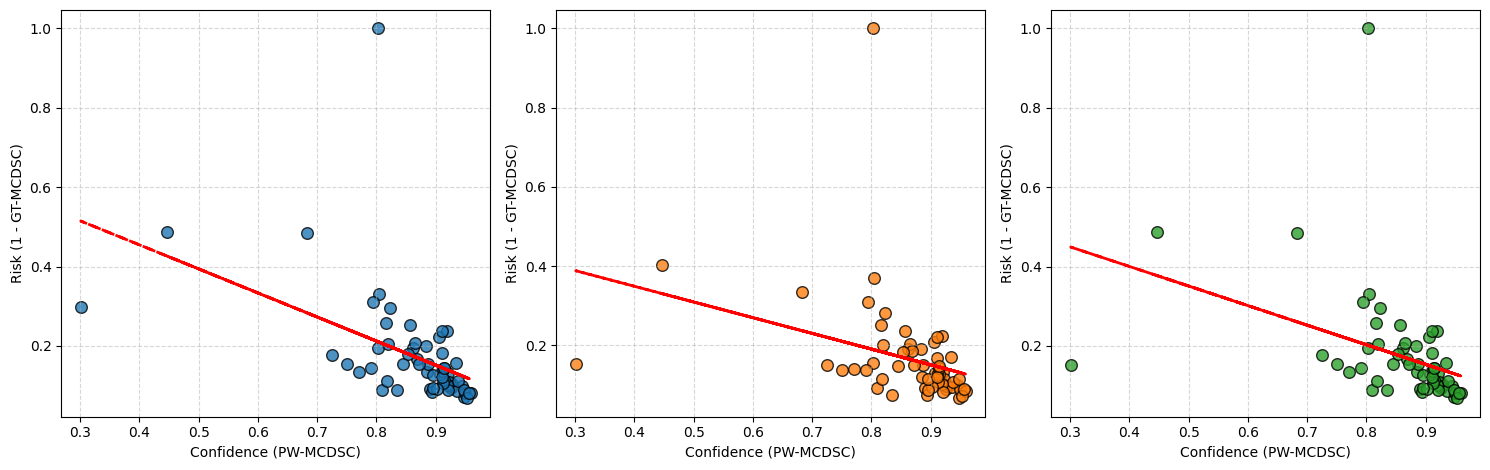

Saved multi-model figure /scratch/radv/share/glioseg/new_run_corrected/segmentation_quality/after_relabeling/scatter_QA_vs_Risk_micro.svg
Correlation summary saved /scratch/radv/share/glioseg/new_run_corrected/segmentation_quality/after_relabeling/correlation_summary_micro.csv
Saved figure to /scratch/radv/share/glioseg/new_run_corrected/segmentation_quality/after_relabeling/risk_coverage_subplots_micro.svg
Saved AUC table to /scratch/radv/share/glioseg/new_run_corrected/segmentation_quality/after_relabeling/risk_coverage_auc_micro.csv
Saved detailed threshold data to /scratch/radv/share/glioseg/new_run_corrected/segmentation_quality/after_relabeling/risk_coverage_detailed_micro.csv


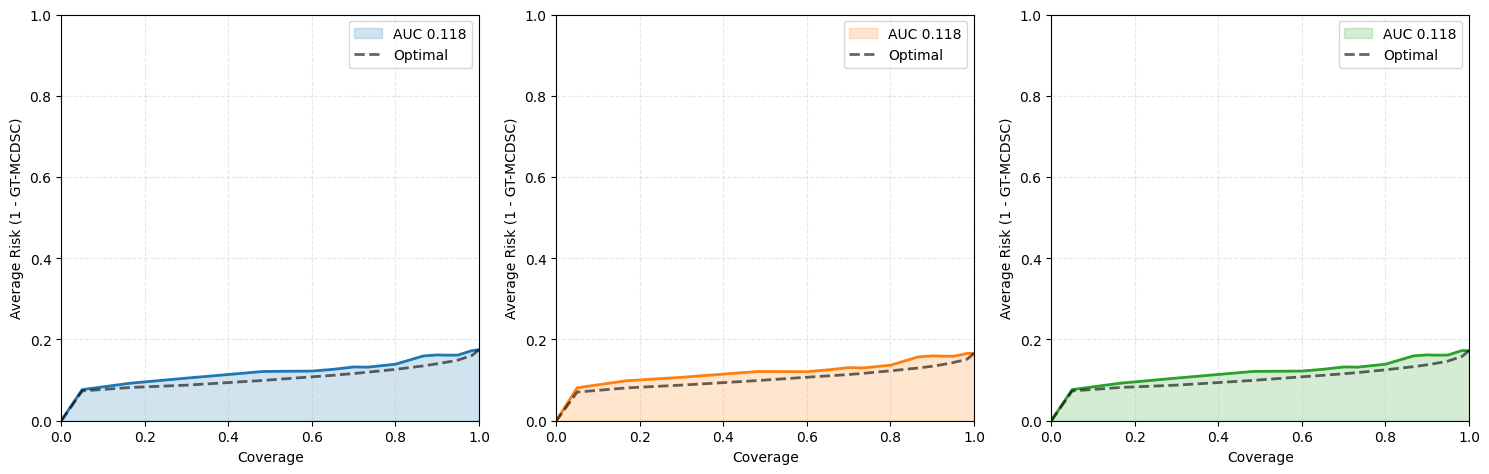

In [9]:
plot_quality_vs_risk(
    confidence_candidates_summary_df=confidence_score_after_relabel,
    multiclass_dice_score_df=multiclass_dice_score_after_relabel,
    model_keys=None,
    output_dir=output_dir_after_relabeling,
    metric_compute="micro",
)

plot_risk_coverage_subplots(
    confidence_candidates_summary_df=confidence_score_after_relabel,
    multiclass_dice_score_df=multiclass_dice_score_after_relabel,
    model_keys=None,
    output_dir=output_dir_after_relabeling,
    metric_compute="micro",
)

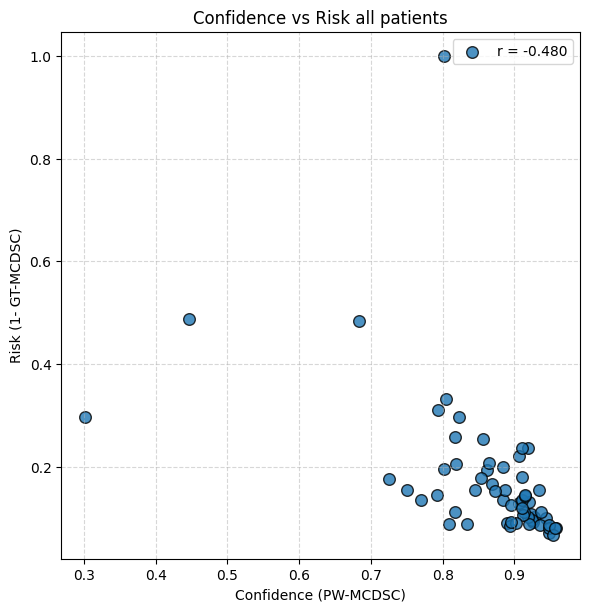

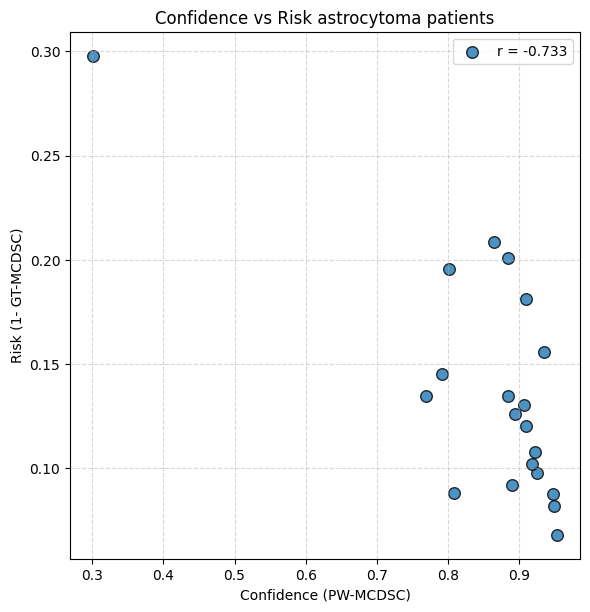

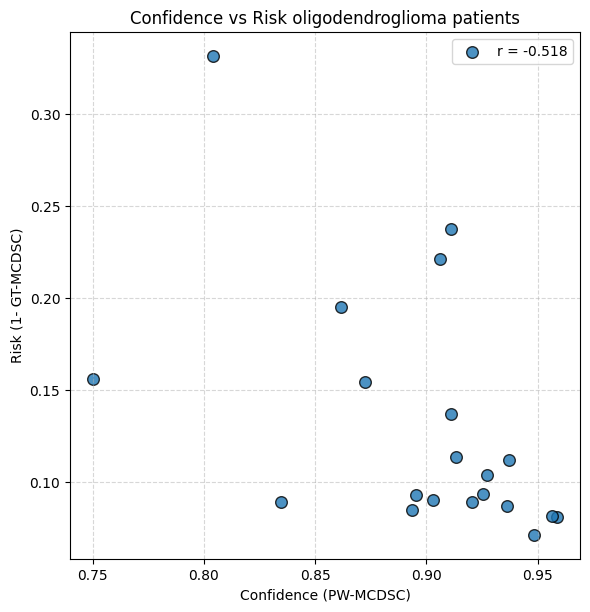

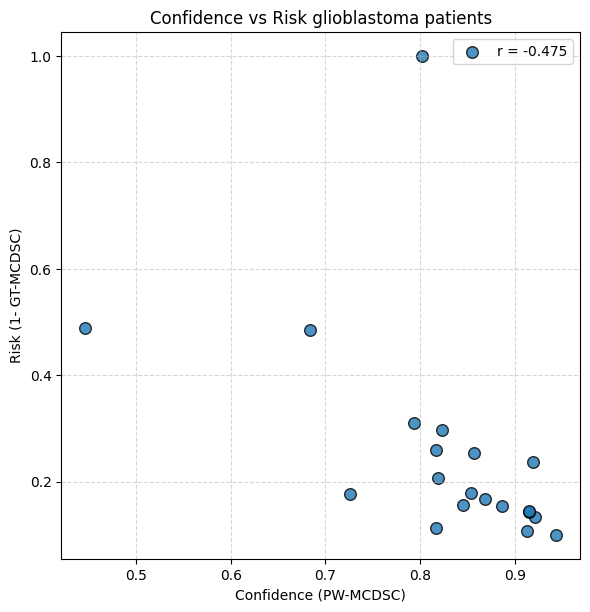

In [10]:
# Important variables 

# print(confidence_score_after_relabel)
# print(multiclass_dice_score_after_relabel) 

# Get the multi-class dice score dataframe per method separated 

multiclass_dice_score_after_relabel_mv = multiclass_dice_score_after_relabel[
    multiclass_dice_score_after_relabel["Method"] == "MV"
].copy()
multiclass_dice_score_after_relabel_staple = multiclass_dice_score_after_relabel[
    multiclass_dice_score_after_relabel["Method"] == "STAPLE"
].copy()
multiclass_dice_score_after_relabel_simple = multiclass_dice_score_after_relabel[
    multiclass_dice_score_after_relabel["Method"] == "SIMPLE"
].copy()

tumor_volumes_df = pd.read_excel("/data/radv/radG/RAD/share/IMAGO/Rotterdam_project/Gonzalo_Juancito/tumor_volumes.xlsx")
tumor_types_df = tumor_volumes_df[["pseudo", "Tumor_type", "Grade"]].copy()
tumor_types_df.rename(columns={"pseudo": "Patient", "Tumor_type": "Tumor type", "Grade": "Tumor grade"}, inplace=True)

# Now only keep the patients that are in the multiclass_dice_score_after_relabel_mv dataframe
tumor_types_df = tumor_types_df[
    tumor_types_df["Patient"].isin(multiclass_dice_score_after_relabel_mv["Patient"].values)
].copy()

# print(tumor_types_df)

# Correct the ones with "Olgo" should be "Oligo", in the tumor_types_df dataframe
tumor_types_df["Tumor type"] = tumor_types_df["Tumor type"].replace("Olgo", "Oligo")

unique_tumor_types = tumor_types_df["Tumor type"].unique()

# Patients per each tumor type
patients_per_tumor_type = {}
for tumor_type in unique_tumor_types:
    patients = tumor_types_df[tumor_types_df["Tumor type"] == tumor_type]["Patient"].values
    patients_per_tumor_type[tumor_type] = patients

# Get confidence and multiclas scores for each tumor type

confidence_subset_astro = confidence_score_after_relabel[
    confidence_score_after_relabel["Patient"].isin(patients_per_tumor_type["Astro"])
].copy()

multiclass_dice_subset_astro_mv = multiclass_dice_score_after_relabel_mv[
    multiclass_dice_score_after_relabel_mv["Patient"].isin(patients_per_tumor_type["Astro"])
].copy()

multiclass_dice_subset_astro_staple = multiclass_dice_score_after_relabel_staple[
    multiclass_dice_score_after_relabel_staple["Patient"].isin(patients_per_tumor_type["Astro"])
].copy()

multiclass_dice_subset_astro_simple = multiclass_dice_score_after_relabel_simple[
    multiclass_dice_score_after_relabel_simple["Patient"].isin(patients_per_tumor_type["Astro"])
].copy()

confidence_subset_oligo = confidence_score_after_relabel[
    confidence_score_after_relabel["Patient"].isin(patients_per_tumor_type["Oligo"])
].copy()

multiclass_dice_subset_oligo_mv = multiclass_dice_score_after_relabel_mv[
    multiclass_dice_score_after_relabel_mv["Patient"].isin(patients_per_tumor_type["Oligo"])
].copy()

multiclass_dice_subset_oligo_staple = multiclass_dice_score_after_relabel_staple[
    multiclass_dice_score_after_relabel_staple["Patient"].isin(patients_per_tumor_type["Oligo"])
].copy()

multiclass_dice_subset_oligo_simple = multiclass_dice_score_after_relabel_simple[
    multiclass_dice_score_after_relabel_simple["Patient"].isin(patients_per_tumor_type["Oligo"])
].copy()

confidence_subset_gbm = confidence_score_after_relabel[
    confidence_score_after_relabel["Patient"].isin(patients_per_tumor_type["glioblastoom"])
].copy()

multiclass_dice_subset_gbm_mv = multiclass_dice_score_after_relabel_mv[
    multiclass_dice_score_after_relabel_mv["Patient"].isin(patients_per_tumor_type["glioblastoom"])
].copy()

multiclass_dice_subset_gbm_staple = multiclass_dice_score_after_relabel_staple[
    multiclass_dice_score_after_relabel_staple["Patient"].isin(patients_per_tumor_type["glioblastoom"])
].copy()

multiclass_dice_subset_gbm_simple = multiclass_dice_score_after_relabel_simple[
    multiclass_dice_score_after_relabel_simple["Patient"].isin(patients_per_tumor_type["glioblastoom"])
].copy()


output_dir = Path("/home/radv/gemosquerarojas/glioseg/glioseg/extras/results")
output_dir_mv = output_dir.joinpath("mv")
output_dir_mv.mkdir(parents=True, exist_ok=True)
output_dir_staple = output_dir.joinpath("staple")
output_dir_staple.mkdir(parents=True, exist_ok=True)
output_dir_simple = output_dir.joinpath("simple")
output_dir_simple.mkdir(parents=True, exist_ok=True)


fig_confidence_vs_risk_all, ax_confidence_vs_risk_all = confidence_vs_risk_figure(
    confidence_candidates_summary_df=confidence_score_after_relabel,
    multiclass_dice_score_df=multiclass_dice_score_after_relabel_mv,
    model_key="MV",
    metric_compute="micro"
)

ax_confidence_vs_risk_all.set_title("Confidence vs Risk all patients")
fig_confidence_vs_risk_all.savefig(output_dir_mv / "confidence_vs_risk_all_patients.svg")

fig_confidence_vs_risk_astro, ax_confidence_vs_risk_astro = confidence_vs_risk_figure(
    confidence_candidates_summary_df=confidence_subset_astro,
    multiclass_dice_score_df=multiclass_dice_subset_astro_mv,
    model_key="MV",
    metric_compute="micro"
)
ax_confidence_vs_risk_astro.set_title("Confidence vs Risk astrocytoma patients")
fig_confidence_vs_risk_astro.savefig(output_dir_mv / "confidence_vs_risk_astrocytoma_patients.svg")

fig_confidence_vs_risk_oligo, ax_confidence_vs_risk_oligo = confidence_vs_risk_figure(
    confidence_candidates_summary_df=confidence_subset_oligo,
    multiclass_dice_score_df=multiclass_dice_subset_oligo_mv,
    model_key="MV",
    metric_compute="micro"
)
ax_confidence_vs_risk_oligo.set_title("Confidence vs Risk oligodendroglioma patients")
fig_confidence_vs_risk_oligo.savefig(output_dir_mv / "confidence_vs_risk_oligodendroglioma_patients.svg")

fig_confidence_vs_risk_gbm, ax_confidence_vs_risk_gbm = confidence_vs_risk_figure(
    confidence_candidates_summary_df=confidence_subset_gbm,
    multiclass_dice_score_df=multiclass_dice_subset_gbm_mv,
    model_key="MV",
    metric_compute="micro"
)
ax_confidence_vs_risk_gbm.set_title("Confidence vs Risk glioblastoma patients")
fig_confidence_vs_risk_gbm.savefig(output_dir_mv / "confidence_vs_risk_glioblastoma_patients.svg")

# fig_coverage_vs_risk_all, ax_coverage_vs_risk_all, _, _ = risk_coverage_figure(
#     confidence_candidates_summary_df=confidence_score_after_relabel,
#     multiclass_dice_score_df=multiclass_dice_score_after_relabel_mv,
#     model_key="MV",
#     metric_compute="micro"
# )

# plot_quality_vs_risk(
#     confidence_candidates_summary_df=confidence_score_after_relabel,
#     multiclass_dice_score_df=multiclass_dice_score_after_relabel_mv,
#     model_keys=None,
#     output_dir=output_dir_after_relabeling,
#     metric_compute="micro",
# )

# print("Confidence vs Risk Astro patients")
# plot_quality_vs_risk(
#     confidence_candidates_summary_df=confidence_subset_astro_mv,
#     multiclass_dice_score_df=multiclass_dice_subset_astro_mv,
#     model_keys=None,
#     output_dir=output_dir_after_relabeling,
#     metric_compute="micro",
# )

# print("Confidence vs Risk Oligo patients") 
# plot_quality_vs_risk(
#     confidence_candidates_summary_df=confidence_subset_oligo_mv,
#     multiclass_dice_score_df=multiclass_dice_subset_oligo_mv,
#     model_keys=None,
#     output_dir=output_dir_after_relabeling,
#     metric_compute="micro",
# )
# print("Confidence vs Risk GBM patients") 
# plot_quality_vs_risk(
#     confidence_candidates_summary_df=confidence_subset_gbm_mv,
#     multiclass_dice_score_df=multiclass_dice_subset_gbm_mv,
#     model_keys=None,
#     output_dir=output_dir_after_relabeling,
#     metric_compute="micro",
# )

# plot_risk_coverage_subplots(
#     confidence_candidates_summary_df=confidence_score_after_relabel,
#     multiclass_dice_score_df=multiclass_dice_score_after_relabel_mv,
#     model_keys=None,
#     output_dir=output_dir_after_relabeling,
#     metric_compute="micro",
# )

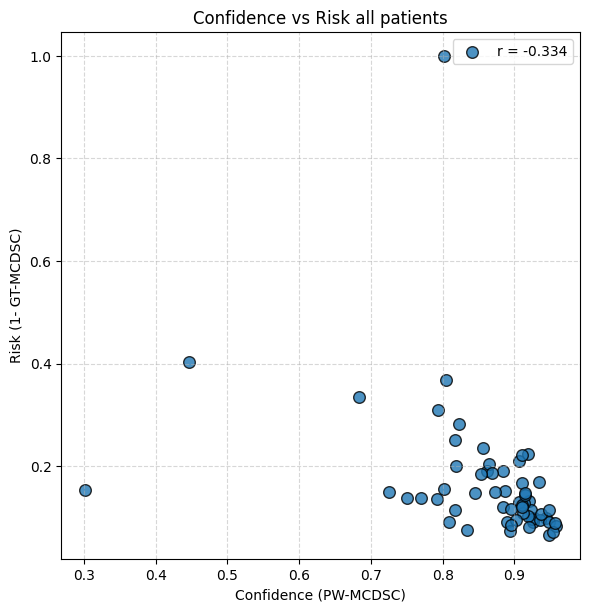

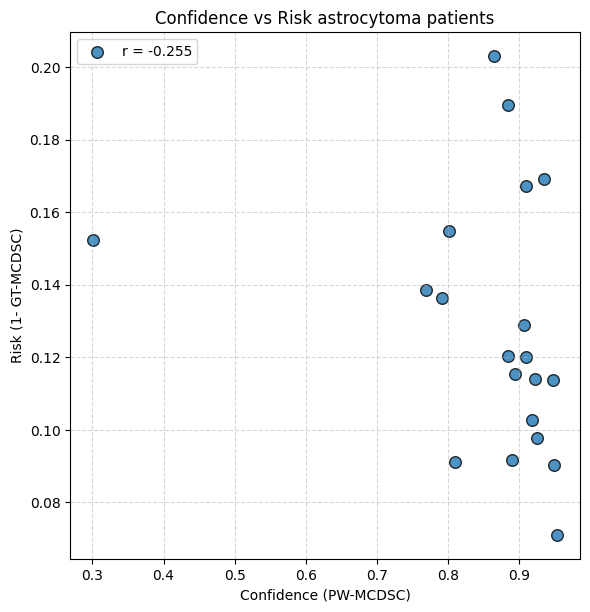

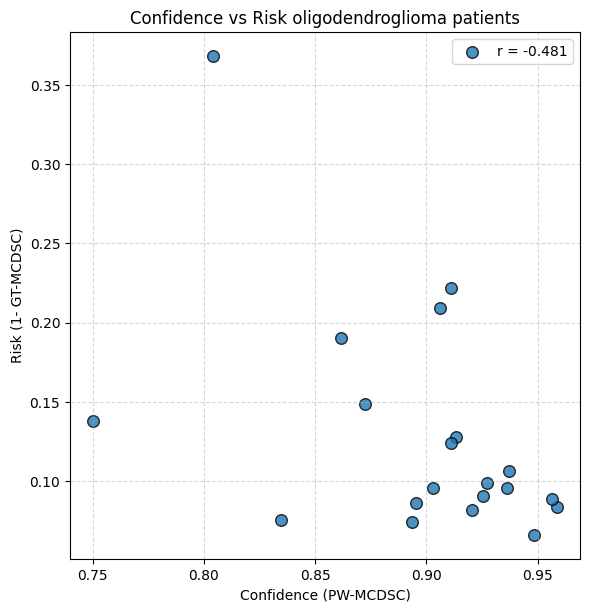

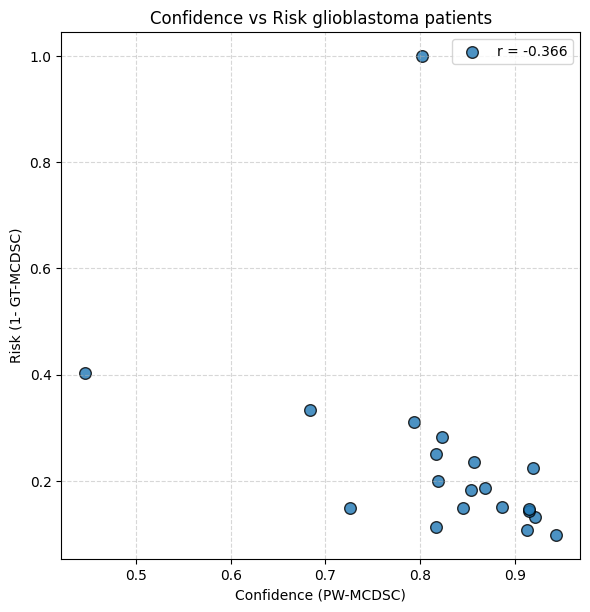

In [11]:
fig_confidence_vs_risk_all, ax_confidence_vs_risk_all = confidence_vs_risk_figure(
    confidence_candidates_summary_df=confidence_score_after_relabel,
    multiclass_dice_score_df=multiclass_dice_score_after_relabel_staple,
    model_key="STAPLE",
    metric_compute="micro"
)

ax_confidence_vs_risk_all.set_title("Confidence vs Risk all patients")
fig_confidence_vs_risk_all.savefig(output_dir_staple / "confidence_vs_risk_all_patients.svg")

fig_confidence_vs_risk_astro, ax_confidence_vs_risk_astro = confidence_vs_risk_figure(
    confidence_candidates_summary_df=confidence_subset_astro,
    multiclass_dice_score_df=multiclass_dice_subset_astro_staple,
    model_key="STAPLE",
    metric_compute="micro"
)
ax_confidence_vs_risk_astro.set_title("Confidence vs Risk astrocytoma patients")
fig_confidence_vs_risk_astro.savefig(output_dir_staple / "confidence_vs_risk_astrocytoma_patients.svg")

fig_confidence_vs_risk_oligo, ax_confidence_vs_risk_oligo = confidence_vs_risk_figure(
    confidence_candidates_summary_df=confidence_subset_oligo,
    multiclass_dice_score_df=multiclass_dice_subset_oligo_staple,
    model_key="STAPLE",
    metric_compute="micro"
)
ax_confidence_vs_risk_oligo.set_title("Confidence vs Risk oligodendroglioma patients")
fig_confidence_vs_risk_oligo.savefig(output_dir_staple / "confidence_vs_risk_oligodendroglioma_patients.svg")

fig_confidence_vs_risk_gbm, ax_confidence_vs_risk_gbm = confidence_vs_risk_figure(
    confidence_candidates_summary_df=confidence_subset_gbm,
    multiclass_dice_score_df=multiclass_dice_subset_gbm_staple,
    model_key="STAPLE",
    metric_compute="micro"
)
ax_confidence_vs_risk_gbm.set_title("Confidence vs Risk glioblastoma patients")
fig_confidence_vs_risk_gbm.savefig(output_dir_staple / "confidence_vs_risk_glioblastoma_patients.svg")

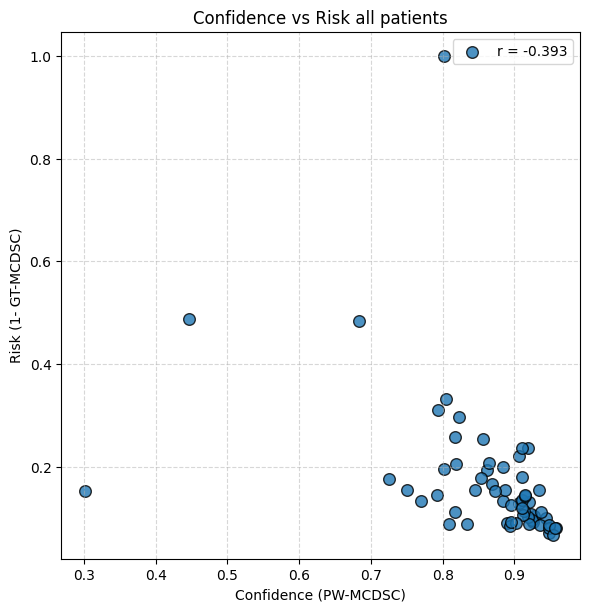

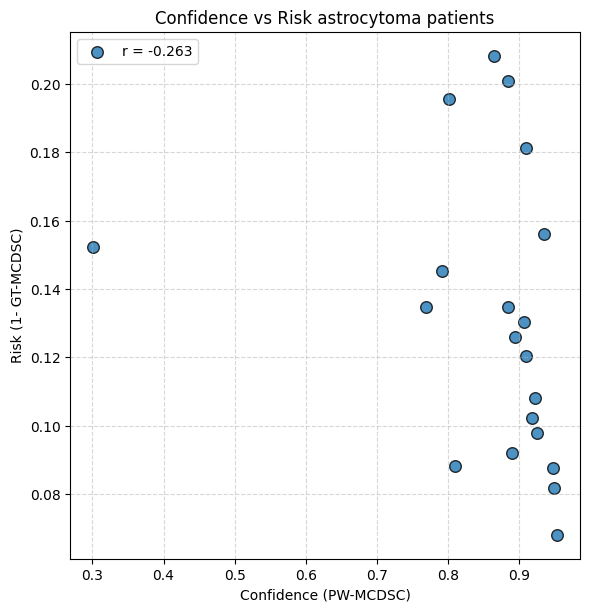

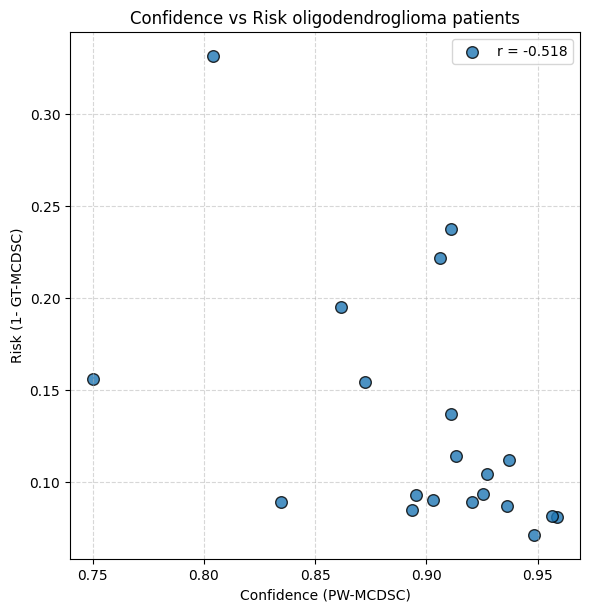

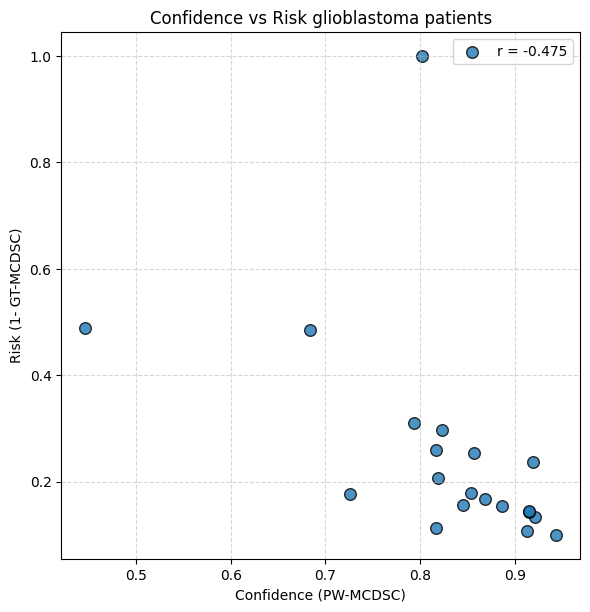

In [12]:
fig_confidence_vs_risk_all, ax_confidence_vs_risk_all = confidence_vs_risk_figure(
    confidence_candidates_summary_df=confidence_score_after_relabel,
    multiclass_dice_score_df=multiclass_dice_score_after_relabel_simple,
    model_key="SIMPLE",
    metric_compute="micro"
)

ax_confidence_vs_risk_all.set_title("Confidence vs Risk all patients")
fig_confidence_vs_risk_all.savefig(output_dir_simple / "confidence_vs_risk_all_patients.svg")

fig_confidence_vs_risk_astro, ax_confidence_vs_risk_astro = confidence_vs_risk_figure(
    confidence_candidates_summary_df=confidence_subset_astro,
    multiclass_dice_score_df=multiclass_dice_subset_astro_simple,
    model_key="SIMPLE",
    metric_compute="micro"
)
ax_confidence_vs_risk_astro.set_title("Confidence vs Risk astrocytoma patients")
fig_confidence_vs_risk_astro.savefig(output_dir_simple / "confidence_vs_risk_astrocytoma_patients.svg")

fig_confidence_vs_risk_oligo, ax_confidence_vs_risk_oligo = confidence_vs_risk_figure(
    confidence_candidates_summary_df=confidence_subset_oligo,
    multiclass_dice_score_df=multiclass_dice_subset_oligo_simple,
    model_key="SIMPLE",
    metric_compute="micro"
)
ax_confidence_vs_risk_oligo.set_title("Confidence vs Risk oligodendroglioma patients")
fig_confidence_vs_risk_oligo.savefig(output_dir_simple / "confidence_vs_risk_oligodendroglioma_patients.svg")

fig_confidence_vs_risk_gbm, ax_confidence_vs_risk_gbm = confidence_vs_risk_figure(
    confidence_candidates_summary_df=confidence_subset_gbm,
    multiclass_dice_score_df=multiclass_dice_subset_gbm_simple,
    model_key="SIMPLE",
    metric_compute="micro"
)
ax_confidence_vs_risk_gbm.set_title("Confidence vs Risk glioblastoma patients")
fig_confidence_vs_risk_gbm.savefig(output_dir_simple / "confidence_vs_risk_glioblastoma_patients.svg")

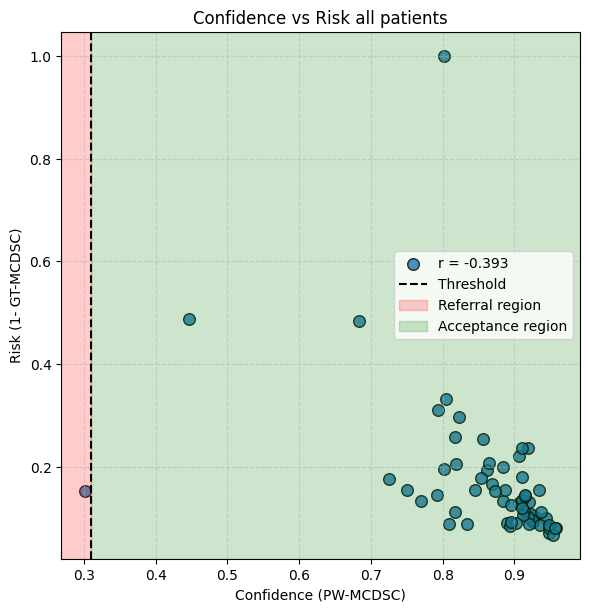

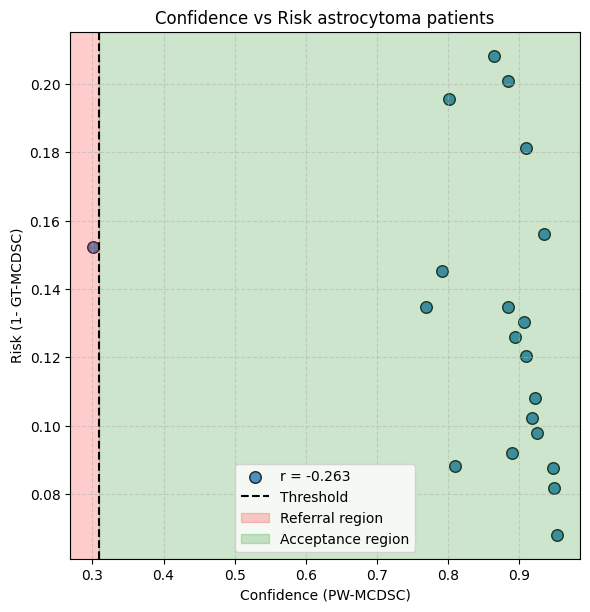

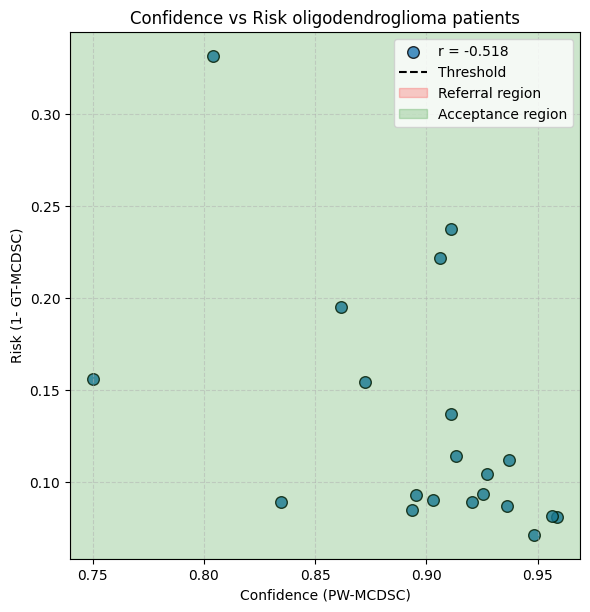

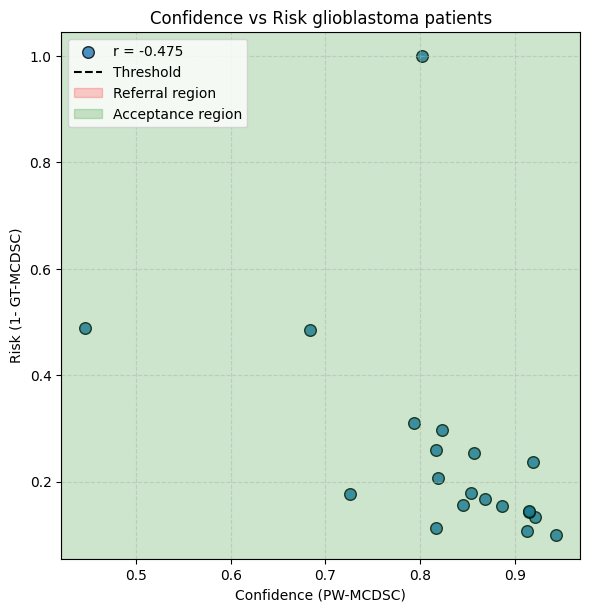

In [13]:
%matplotlib inline 
from IPython.display import display

confidence_score_after_relabel_all = confidence_score_after_relabel[["Patient", "PW-MCDSC"]].copy()
# Order by ascending PW-MCDSC
confidence_score_after_relabel_all = confidence_score_after_relabel_all.sort_values(by="PW-MCDSC", ascending=True)

# We find the threshold that would allow us a coverage of 0.9 
desired_coverage = 0.9

threshold = np.percentile(
    confidence_score_after_relabel_all["PW-MCDSC"].values, (1 - desired_coverage)
)


# Force the view to include all points
ax_confidence_vs_risk_all.relim()
ax_confidence_vs_risk_all.autoscale_view()

# Get exact axis limits including Matplotlib padding
x_min, x_max = ax_confidence_vs_risk_all.get_xlim()
y_min, y_max = ax_confidence_vs_risk_all.get_ylim()

ax_confidence_vs_risk_all.set_xlim(x_min, x_max)
ax_confidence_vs_risk_all.set_ylim(y_min, y_max)

# Vertical threshold line
ax_confidence_vs_risk_all.axvline(x=threshold, color="black", linestyle="--", label="Threshold")

# Shade left of threshold (red)
ax_confidence_vs_risk_all.fill_betweenx(
    y=[y_min, y_max],
    x1=x_min,
    x2=threshold,
    color="red",
    alpha=0.2,
    label="Referral region"
)

# Shade right of threshold (green)
ax_confidence_vs_risk_all.fill_betweenx(
    y=[y_min, y_max],
    x1=threshold,
    x2=x_max,
    color="green",
    alpha=0.2,
    label="Acceptance region"
)

# Optional title & legend
ax_confidence_vs_risk_all.set_title("Confidence vs Risk all patients")
ax_confidence_vs_risk_all.legend()

from IPython.display import display
display(fig_confidence_vs_risk_all)

# Now the same for astrocytoma, oligodendroglioma, and glioblastoma patients

# Force the view to include all points
ax_confidence_vs_risk_astro.relim()
ax_confidence_vs_risk_astro.autoscale_view()

# Get exact axis limits including Matplotlib padding
x_min, x_max = ax_confidence_vs_risk_astro.get_xlim()
y_min, y_max = ax_confidence_vs_risk_astro.get_ylim()

ax_confidence_vs_risk_astro.set_xlim(x_min, x_max)
ax_confidence_vs_risk_astro.set_ylim(y_min, y_max)

# Vertical threshold line
ax_confidence_vs_risk_astro.axvline(x=threshold, color="black", linestyle="--", label="Threshold")  

# Shade left of threshold (red)
ax_confidence_vs_risk_astro.fill_betweenx(
    y=[y_min, y_max],
    x1=x_min,
    x2=threshold,
    color="red",
    alpha=0.2,
    label="Referral region"
)

# Shade right of threshold (green)
ax_confidence_vs_risk_astro.fill_betweenx(
    y=[y_min, y_max],
    x1=threshold,
    x2=x_max,
    color="green",
    alpha=0.2,
    label="Acceptance region"
) 

# Optional title & legend
ax_confidence_vs_risk_astro.set_title("Confidence vs Risk astrocytoma patients")
ax_confidence_vs_risk_astro.legend()    

from IPython.display import display
display(fig_confidence_vs_risk_astro)

# Now the same for oligodendroglioma patients
# Force the view to include all points
ax_confidence_vs_risk_oligo.relim()
ax_confidence_vs_risk_oligo.autoscale_view()

# Get exact axis limits including Matplotlib padding
x_min, x_max = ax_confidence_vs_risk_oligo.get_xlim()
y_min, y_max = ax_confidence_vs_risk_oligo.get_ylim()

ax_confidence_vs_risk_oligo.set_xlim(x_min, x_max)
ax_confidence_vs_risk_oligo.set_ylim(y_min, y_max)

# Vertical threshold line
ax_confidence_vs_risk_oligo.axvline(x=threshold, color="black", linestyle="--", label="Threshold")
# Shade left of threshold (red)
ax_confidence_vs_risk_oligo.fill_betweenx(
    y=[y_min, y_max],
    x1=x_min,
    x2=threshold,
    color="red",
    alpha=0.2,
    label="Referral region"
)
# Shade right of threshold (green)
ax_confidence_vs_risk_oligo.fill_betweenx(
    y=[y_min, y_max],
    x1=threshold,
    x2=x_max,
    color="green",
    alpha=0.2,
    label="Acceptance region"
)
# Optional title & legend
ax_confidence_vs_risk_oligo.set_title("Confidence vs Risk oligodendroglioma patients")
ax_confidence_vs_risk_oligo.legend()
from IPython.display import display
display(fig_confidence_vs_risk_oligo)
# Now the same for glioblastoma patients
# Force the view to include all points
ax_confidence_vs_risk_gbm.relim()
ax_confidence_vs_risk_gbm.autoscale_view()  
# Get exact axis limits including Matplotlib padding
x_min, x_max = ax_confidence_vs_risk_gbm.get_xlim()
y_min, y_max = ax_confidence_vs_risk_gbm.get_ylim()
ax_confidence_vs_risk_gbm.set_xlim(x_min, x_max)
ax_confidence_vs_risk_gbm.set_ylim(y_min, y_max)
# Vertical threshold line
ax_confidence_vs_risk_gbm.axvline(x=threshold, color="black", linestyle="--", label="Threshold")
# Shade left of threshold (red)
ax_confidence_vs_risk_gbm.fill_betweenx(
    y=[y_min, y_max],
    x1=x_min,
    x2=threshold,
    color="red",
    alpha=0.2,
    label="Referral region"
)
# Shade right of threshold (green)
ax_confidence_vs_risk_gbm.fill_betweenx(
    y=[y_min, y_max],
    x1=threshold,
    x2=x_max,
    color="green",
    alpha=0.2,
    label="Acceptance region"
)
# Optional title & legend
ax_confidence_vs_risk_gbm.set_title("Confidence vs Risk glioblastoma patients")
ax_confidence_vs_risk_gbm.legend()
from IPython.display import display
display(fig_confidence_vs_risk_gbm)


In [ ]:
# Let's do an analysis of the differences between doing a mean aggregation per model vs mean aggregation of all combinations per patient 

patient_ids = extended_confidence_after_relabel["Patient"].tolist()
patient_mcdsc_combinations = extended_confidence_after_relabel["PW-MCDSC-combinations"].tolist()

In [ ]:
import numpy as np
from collections import defaultdict

all_patients_model_means = []   # list of dicts, one per patient

for d in patient_mcdsc_combinations:
    model_scores = defaultdict(list)

    # collect scores per model *within this patient*
    for (m1, m2), score in d.items():
        score = float(score)
        model_scores[m1].append(score)
        model_scores[m2].append(score)

    # compute mean per model
    model_mean = {model: np.mean(scores) for model, scores in model_scores.items()}
    all_patients_model_means.append(model_mean)

In [16]:
final_mean = [float(np.mean(list(patient_info.values()))) for patient_info in all_patients_model_means] 

In [17]:
final_mean_per_patient = {"Patients" : patient_ids, "Final_Mean": final_mean}

In [12]:
# def compute_confidence_score(input_dir, segmentation_dict, labels, output_dir):

#     """
#     Compute confidence score based on model ensemble candidates.
#     For each model, average its mean per-label Dice score against all other models.
#     """

#     if not isinstance(input_dir, Path):
#         input_dir = Path(input_dir)
#     if not isinstance(output_dir, Path):
#         output_dir = Path(output_dir)

#     all_results = []

#     for patient in input_dir.iterdir():

#         segmentations_dir = patient.joinpath("SEGMENTATIONS", "NIFTI")

#         # --- Load all model segmentations ---
#         seg_images = {}
#         for method, seg_file_name in segmentation_dict.items():
#             seg_file = segmentations_dir.joinpath(
#                 constants.TUMOR_MASK_NAME + seg_file_name + "_T1GD"
#             ).with_suffix(constants.NIFTI_EXTENSION)

#             if not seg_file.exists() and "_relabelled" in seg_file_name:
#                 seg_file_name = seg_file_name.replace("_relabelled", "")
#                 print(f"Segmentation file {seg_file} does not exist, and its relabelled")
#                 print(f"Using instead {seg_file_name}")
#                 seg_file = segmentations_dir.joinpath(
#                     constants.TUMOR_MASK_NAME + seg_file_name + "_T1GD"
#                 ).with_suffix(constants.NIFTI_EXTENSION)

#             if seg_file.exists():
#                 seg_images[method] = sitk.ReadImage(str(seg_file), sitk.sitkUInt8)
#             else:
#                 print(f"Skipping {method}: file not found {seg_file}")

#         methods = list(seg_images.keys())
#         if len(methods) < 2:
#             print(f"Skipping {patient.name}: less than 2 segmentations.")
#             continue

#         # --- Initialize per-model accumulators ---
#         multiclass_dice_macro_sums = {m: 0.0 for m in methods}
#         multiclass_dice_macro_counts = {m: 0 for m in methods}

#         multiclass_dice_micro_sums = {m: 0.0 for m in methods}
#         multiclass_dice_micro_counts = {m: 0 for m in methods}

#         # --- Pairwise comparisons ---

#         for m1, m2 in itertools.combinations(methods, 2):
#             seg1, seg2 = seg_images[m1], seg_images[m2]

#             if not same_physical_space(seg1, seg2):
#                 seg2.CopyInformation(seg1)

#             # Dice per label → mean per pair
#             per_label_dices = []

#             total_intersection_pair = 0
#             total_union_pair = 0

#             for label in labels:

#                 s1_label = extract_label(seg1, label)
#                 s2_label = extract_label(seg2, label)
#                 dice = compute_dice_score(s1_label, s2_label)

#                 s1_arr = sitk.GetArrayFromImage(s1_label) > 0
#                 s2_arr = sitk.GetArrayFromImage(s2_label) > 0

#                 total_intersection_pair += np.sum(s1_arr & s2_arr)
#                 total_union_pair += np.sum(s1_arr) + np.sum(s2_arr)

#                 per_label_dices.append(dice)

#             multiclass_dice_macro = np.mean(per_label_dices)
#             multiclass_dice_micro = 2 * total_intersection_pair / (total_union_pair + 1e-6)

#             # Add contribution to both models
#             multiclass_dice_macro_sums[m1] += multiclass_dice_macro
#             multiclass_dice_macro_sums[m2] += multiclass_dice_macro
#             multiclass_dice_macro_counts[m1] += 1
#             multiclass_dice_macro_counts[m2] += 1

#             # Add contribution to both models (multiclass)
#             multiclass_dice_micro_sums[m1] += multiclass_dice_micro
#             multiclass_dice_micro_sums[m2] += multiclass_dice_micro
#             multiclass_dice_micro_counts[m1] += 1
#             multiclass_dice_micro_counts[m2] += 1

#         # --- Compute per-model mean dice (vs all others)---
#         for method in methods:

#             confidence_dice_macro = (
#                 multiclass_dice_macro_sums[method] / multiclass_dice_macro_counts[method]
#             )
#             confidence_dice_micro = (
#                 multiclass_dice_micro_sums[method] / multiclass_dice_micro_counts[method]
#             )

#             all_results.append(
#                 {
#                     "Patient": patient.name,
#                     "Method": method,
#                     "PW-DSC": confidence_dice_macro,
#                     "PW-MCDSC": confidence_dice_micro,
#                 }
#             )

#     # --- Save results ---
#     results = pd.DataFrame(all_results)
#     output_file = output_dir.joinpath("confidence_candidates_extended_wrong.csv")
#     results.to_csv(output_file, index=False)
#     print(f"Quality assessment results saved to {output_file}")

#     mean_results_per_patient = (
#         results.groupby("Patient")[["PW-DSC", "PW-MCDSC"]].mean().reset_index()
#     )
#     output_file_mean = output_dir.joinpath("confidence_candidates_summary_wrong.csv")
#     mean_results_per_patient.to_csv(output_file_mean, index=False)
#     print(f"Mean per-patient quality assessment results saved to {output_file_mean}")

#     # Make another data

#     return {"Confidence Extended": results, "Confidence Summary": mean_results_per_patient}

In [13]:
# confidence_score_before_relabel_wrong = compute_confidence_score(
#     input_dir=input_dir,
#     segmentation_dict=segmentation_files_dict_before_relabeling,
#     labels=labels,
#     output_dir=wrong_results_before_relabeling,
# )

# confidence_score_after_relabel_wrong = compute_confidence_score(
#     input_dir=input_dir,
#     segmentation_dict=segmentation_files_dict_after_relabeling,
#     labels=labels,
#     output_dir=wrong_results_after_relabeling,
# )

In [14]:
# multiclass_dice_score_before_relabel.to_csv(
#     wrong_results_before_relabeling.joinpath("multiclass_dice_score.csv"), index=False
# )

# multiclass_dice_score_after_relabel.to_csv(
#     wrong_results_after_relabeling.joinpath("multiclass_dice_score.csv"), index=False
# )

In [15]:
# print(confidence_score_after_relabel_wrong["Confidence Summary"]["PW-MCDSC"])

In [16]:
# print(final_mean_per_patient["Final_Mean"])

Saved multi-model figure /scratch/radv/share/glioseg/new_run_corrected/segmentation_quality/before_relabeling/scatter_QA_vs_Risk_micro.svg
Correlation summary saved /scratch/radv/share/glioseg/new_run_corrected/segmentation_quality/before_relabeling/correlation_summary_micro.csv


Saved multi-model figure /scratch/radv/share/glioseg/new_run_corrected/segmentation_quality/before_relabeling/scatter_QA_vs_Risk_macro.svg
Correlation summary saved /scratch/radv/share/glioseg/new_run_corrected/segmentation_quality/before_relabeling/correlation_summary_macro.csv
Saved multi-model figure /scratch/radv/share/glioseg/new_run_corrected/segmentation_quality/after_relabeling/scatter_QA_vs_Risk_micro.svg
Correlation summary saved /scratch/radv/share/glioseg/new_run_corrected/segmentation_quality/after_relabeling/correlation_summary_micro.csv
Saved multi-model figure /scratch/radv/share/glioseg/new_run_corrected/segmentation_quality/after_relabeling/scatter_QA_vs_Risk_macro.svg
Correlation summary saved /scratch/radv/share/glioseg/new_run_corrected/segmentation_quality/after_relabeling/correlation_summary_macro.csv
Saved figure to /scratch/radv/share/glioseg/new_run_corrected/segmentation_quality/before_relabeling/risk_coverage_subplots_micro.svg
Saved AUC table to /scratch/ra

(   Method       AUC  AUC_Optimal  Area_Between     Score
 0      MV  0.116148     0.081532      0.034616  0.075382
 1  STAPLE  0.113394     0.078800      0.034593  0.073993
 2  SIMPLE  0.115340     0.080693      0.034647  0.074993,
      Method  Threshold  Coverage  Average_Risk  Optimal_Risk
 0        MV      0.000  1.000000      0.229410      0.229410
 1        MV      0.017  1.000000      0.229410      0.229410
 2        MV      0.034  1.000000      0.229410      0.229410
 3        MV      0.051  1.000000      0.229410      0.229410
 4        MV      0.068  1.000000      0.229410      0.229410
 ..      ...        ...       ...           ...           ...
 175  SIMPLE      0.932  0.250000      0.035763      0.029774
 176  SIMPLE      0.949  0.233333      0.035650      0.029328
 177  SIMPLE      0.966  0.166667      0.034661      0.027729
 178  SIMPLE      0.983  0.033333      0.024880      0.023200
 179  SIMPLE      1.000  0.000000      0.000000      0.000000
 
 [180 rows x 5 column

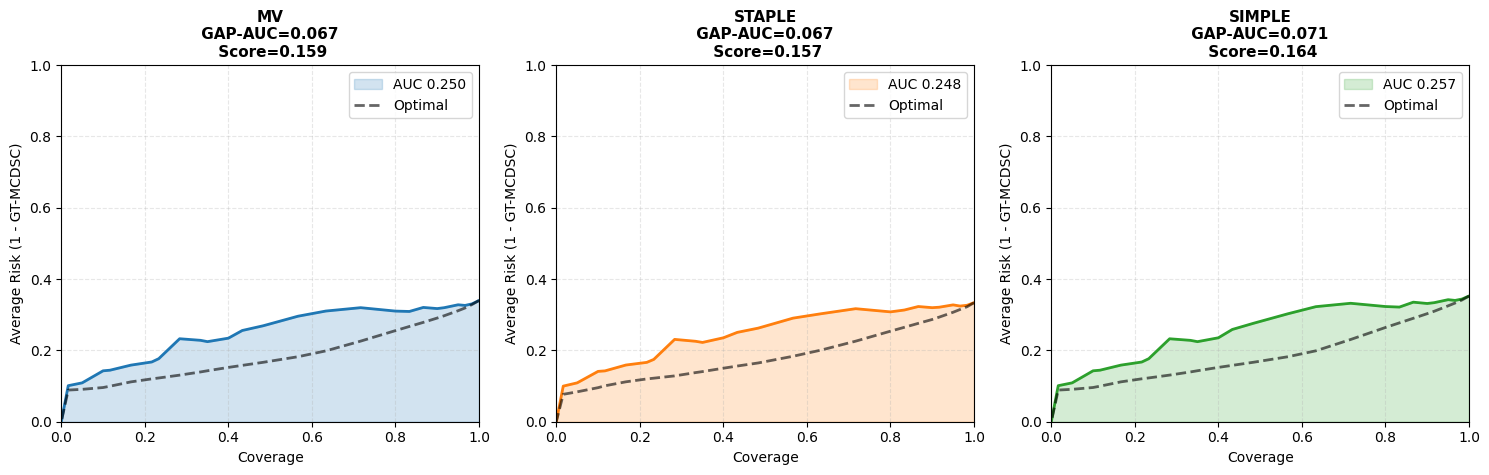

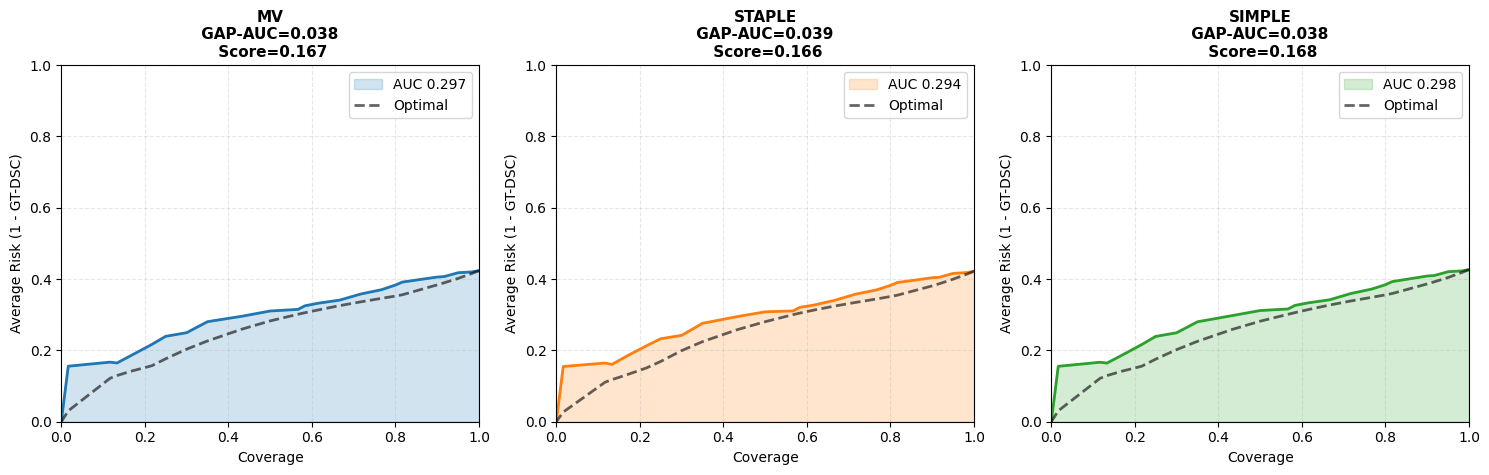

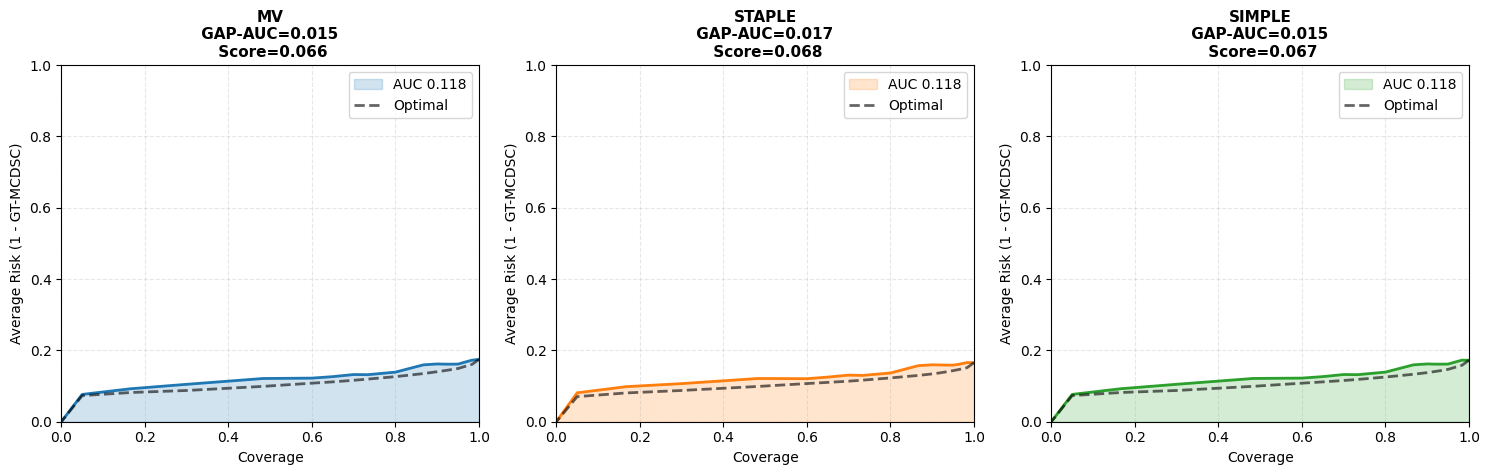

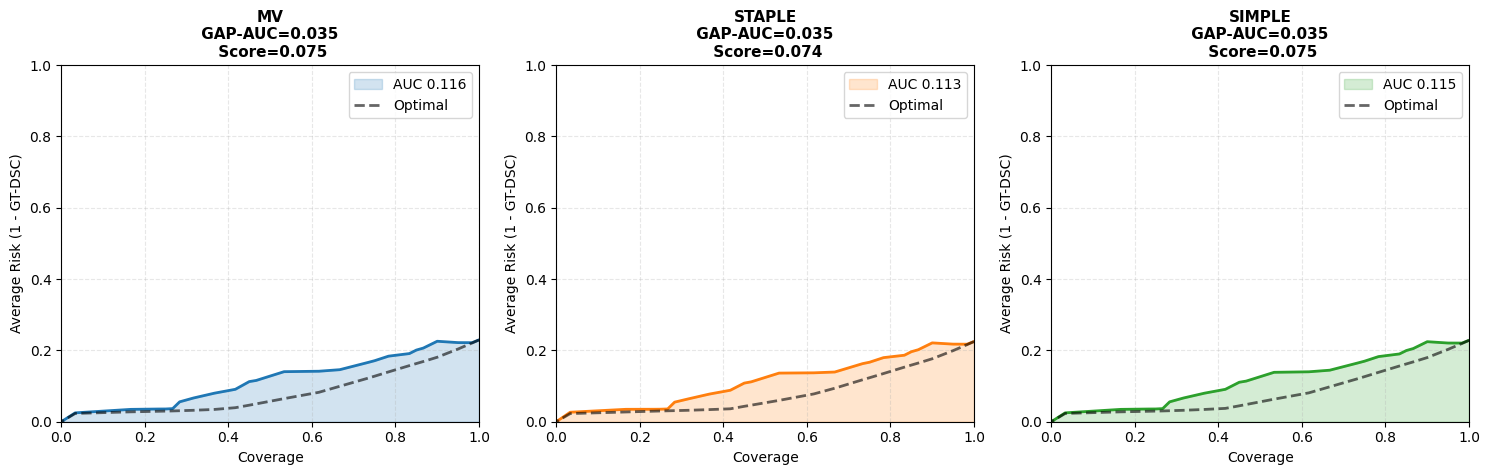

In [17]:
plot_quality_vs_risk(
    confidence_candidates_summary_df=confidence_score_before_relabel,
    multiclass_dice_score_df=multiclass_dice_score_before_relabel,
    model_keys=None,
    output_dir=output_dir_before_relabeling,
    metric_compute="micro",
)
plot_quality_vs_risk(
    confidence_candidates_summary_df=confidence_score_before_relabel,
    multiclass_dice_score_df=multiclass_dice_score_before_relabel,
    model_keys=None,
    output_dir=output_dir_before_relabeling,
    metric_compute="macro",
)
plot_quality_vs_risk(
    confidence_candidates_summary_df=confidence_score_after_relabel,
    multiclass_dice_score_df=multiclass_dice_score_after_relabel,
    model_keys=None,
    output_dir=output_dir_after_relabeling,
    metric_compute="micro",
)
plot_quality_vs_risk(
    confidence_candidates_summary_df=confidence_score_after_relabel,
    multiclass_dice_score_df=multiclass_dice_score_after_relabel,
    model_keys=None,
    output_dir=output_dir_after_relabeling,
    metric_compute="macro",
)

plot_risk_coverage_subplots(
    confidence_candidates_summary_df=confidence_score_before_relabel,
    multiclass_dice_score_df=multiclass_dice_score_before_relabel,
    model_keys=None,
    output_dir=output_dir_before_relabeling,
    metric_compute="micro",
)
plot_risk_coverage_subplots(
    confidence_candidates_summary_df=confidence_score_before_relabel,
    multiclass_dice_score_df=multiclass_dice_score_before_relabel,
    model_keys=None,
    output_dir=output_dir_before_relabeling,
    metric_compute="macro",
)
plot_risk_coverage_subplots(
    confidence_candidates_summary_df=confidence_score_after_relabel,
    multiclass_dice_score_df=multiclass_dice_score_after_relabel,
    model_keys=None,
    output_dir=output_dir_after_relabeling,
    metric_compute="micro",
)
plot_risk_coverage_subplots(
    confidence_candidates_summary_df=confidence_score_after_relabel,
    multiclass_dice_score_df=multiclass_dice_score_after_relabel,
    model_keys=None,
    output_dir=output_dir_after_relabeling,
    metric_compute="macro",
)


In [18]:
print("hi")

hi


In [26]:
confidence_score_after_relabel

,Patient,PW-DSC,PW-MCDSC
0,IM1425,0.509570,0.909951
1,IM0401,0.468754,0.802088
2,IM0373,0.613633,0.883969
3,IM0400,0.982704,0.948111
4,IM0273,0.708340,0.922879
5,IM0256,0.982778,0.948334
6,IM0352,0.978800,0.936399
7,IM0398,0.776150,0.802173
8,IM0031,0.816894,0.943706
9,IM0801,0.973540,0.920621


In [27]:
confidence_score_after_relabel_wrong["Confidence Summary"]

,Patient,PW-DSC,PW-MCDSC
0,IM0015,0.590400,0.906118
1,IM0016,0.792977,0.920718
2,IM0031,0.816894,0.943706
3,IM0191,0.651053,0.683228
4,IM0256,0.982778,0.948334
5,IM0267,0.543967,0.927172
6,IM0268,0.916739,0.750216
7,IM0273,0.708340,0.922879
8,IM0289,0.622690,0.925365
9,IM0309,0.708444,0.925169


In [43]:
# Order dataframe by patient ID 

confidence_score_after_relabel_ordered = confidence_score_after_relabel.sort_values(by="Patient")
confidence_score_after_relabel_wrong_ordered = confidence_score_after_relabel_wrong["Confidence Summary"].sort_values(by="Patient")
multiclass_dice_score_after_relabel_ordered = multiclass_dice_score_after_relabel.sort_values(by="Patient")

pw_mcdsc_correct = confidence_score_after_relabel_ordered["PW-MCDSC"].values
pw_mcdsc_wrong = confidence_score_after_relabel_wrong_ordered["PW-MCDSC"].values

for correct_score, incorrect_score in zip(pw_mcdsc_correct, pw_mcdsc_wrong):
    if not correct_score == incorrect_score:
        print(f"Mismatch: {correct_score} vs {incorrect_score}")

Mismatch: 0.7502164780796486 vs 0.7502164780796488
Mismatch: 0.9251685308245756 vs 0.9251685308245758
Mismatch: 0.9103976430221261 vs 0.9103976430221262
Mismatch: 0.9373085029297996 vs 0.9373085029297998
Mismatch: 0.8093079244344678 vs 0.8093079244344679
Mismatch: 0.8902644875334405 vs 0.8902644875334402
Mismatch: 0.893493398900922 vs 0.8934933989009218
Mismatch: 0.8847362948211283 vs 0.8847362948211284
Mismatch: 0.8170041222415925 vs 0.8170041222415927
Mismatch: 0.9109560167893939 vs 0.9109560167893941
Mismatch: 0.8645349933172538 vs 0.8645349933172536
Mismatch: 0.9108932431101848 vs 0.9108932431101847


Boolean Series key will be reindexed to match DataFrame index.


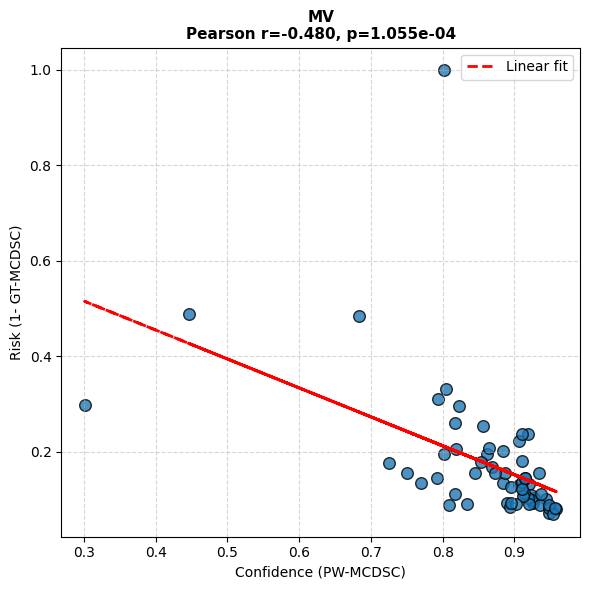

   Pearson r = -0.480, p = 1.055e-04


In [45]:
 
# --- Handle single vs multiple models ---
model = "MV"
confidence_key = "PW-MCDSC"
GT_key = "GT-MCDSC"
multiclass_dice_model = multiclass_dice_score_after_relabel_ordered[
    multiclass_dice_score_after_relabel["Method"] == model
].copy()

if multiclass_dice_model.empty:
    print(f"No entries found for model '{model}'")

multiclass_dice_model["Risk"] = 1 - multiclass_dice_model[GT_key]

x, y = (
    confidence_score_after_relabel_ordered[confidence_key].values,
    multiclass_dice_model["Risk"].values,
)

r_value, p_value = pearsonr(x, y)
slope, intercept = np.polyfit(x, y, 1)

plt.figure(figsize=(6, 6))
plt.scatter(x, y, color="tab:blue", edgecolor="k", s=70, alpha=0.8)
plt.plot(
    x, slope * x + intercept, color="red", linestyle="--", linewidth=2, label="Linear fit"
)
plt.title(
    f"{model}\nPearson r={r_value:.3f}, p={p_value:.3e}", fontsize=11, fontweight="bold"
)
plt.xlabel(f"Confidence ({confidence_key})")
plt.ylabel(f"Risk (1- {GT_key})")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()
plt.close()
print(f"   Pearson r = {r_value:.3f}, p = {p_value:.3e}")


,Patient,Method,GT-DSC,GT-MCDSC
0,IM1425,MV,0.959828,0.879483
1,IM1425,STAPLE,0.959987,0.879962
2,IM1425,SIMPLE,0.959828,0.879483
3,IM0401,MV,0.934759,0.804277
4,IM0401,STAPLE,0.948447,0.845342
...,...,...,...,...
175,IM1428,STAPLE,0.820308,0.852874
176,IM1428,SIMPLE,0.816922,0.854606
177,IM1411,MV,0.900720,0.702161
178,IM1411,STAPLE,0.949195,0.847586


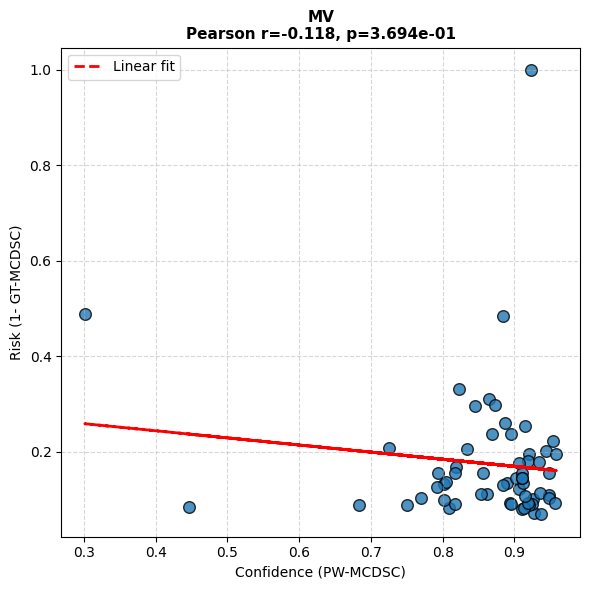

   Pearson r = -0.118, p = 3.694e-01


In [41]:
 
# --- Handle single vs multiple models ---
model = "MV"
confidence_key = "PW-MCDSC"
GT_key = "GT-MCDSC"
multiclass_dice_model = multiclass_dice_score_after_relabel[
    multiclass_dice_score_after_relabel["Method"] == model
].copy()

if multiclass_dice_model.empty:
    print(f"No entries found for model '{model}'")

multiclass_dice_model["Risk"] = 1 - multiclass_dice_model[GT_key]

x, y = (
    confidence_score_after_relabel_wrong["Confidence Summary"][confidence_key].values,
    multiclass_dice_model["Risk"].values,
)

r_value, p_value = pearsonr(x, y)
slope, intercept = np.polyfit(x, y, 1)

plt.figure(figsize=(6, 6))
plt.scatter(x, y, color="tab:blue", edgecolor="k", s=70, alpha=0.8)
plt.plot(
    x, slope * x + intercept, color="red", linestyle="--", linewidth=2, label="Linear fit"
)
plt.title(
    f"{model}\nPearson r={r_value:.3f}, p={p_value:.3e}", fontsize=11, fontweight="bold"
)
plt.xlabel(f"Confidence ({confidence_key})")
plt.ylabel(f"Risk (1- {GT_key})")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()
plt.close()
print(f"   Pearson r = {r_value:.3f}, p = {p_value:.3e}")
